<a href="https://colab.research.google.com/github/AmiBuch/exp-forecasting-methods/blob/main/scripts/darts/64_24_baselining_darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install darts
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from scipy import stats
from darts.metrics import metrics

                     PM2.5 (µg/m³)  PM10 (µg/m³)  NO (µg/m³)  NO2 (µg/m³)  \
Timestamp                                                                   
2022-01-01 00:00:00        273.550       386.220     249.030       54.670   
2022-01-01 01:00:00        268.870       432.990     294.770       50.750   
2022-01-01 02:00:00        258.020       396.280     247.480       50.370   
2022-01-01 03:00:00        194.910       297.690     152.660       45.180   
2022-01-01 04:00:00        198.000       314.810     123.040       41.780   
...                            ...           ...         ...          ...   
2023-12-31 19:00:00        222.608       412.838      43.690       18.388   
2023-12-31 20:00:00        213.442       366.385      42.690       15.850   
2023-12-31 21:00:00        234.645       346.625      40.540       15.850   
2023-12-31 22:00:00        206.625       340.345      39.148       13.442   
2023-12-31 23:00:00        175.335       277.898      39.755       12.882   

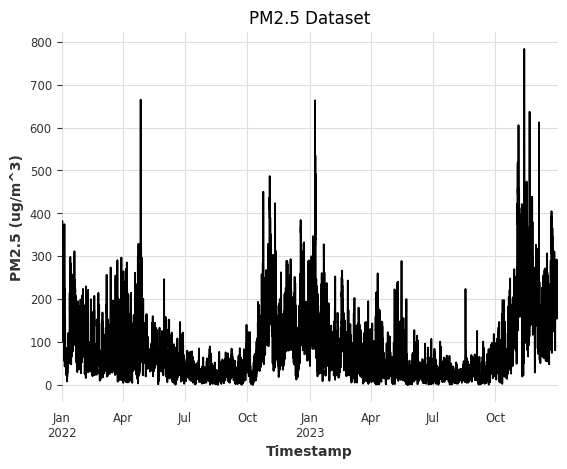

Timestamp
2022-01-01 00:00:00    5.615133
2022-01-01 01:00:00    5.597940
2022-01-01 02:00:00    5.556905
2022-01-01 03:00:00    5.277655
2022-01-01 04:00:00    5.293305
                         ...   
2023-12-31 19:00:00    5.409895
2023-12-31 20:00:00    5.368039
2023-12-31 21:00:00    5.462326
2023-12-31 22:00:00    5.335734
2023-12-31 23:00:00    5.172386
Name: PM2.5 (µg/m³), Length: 17520, dtype: float64


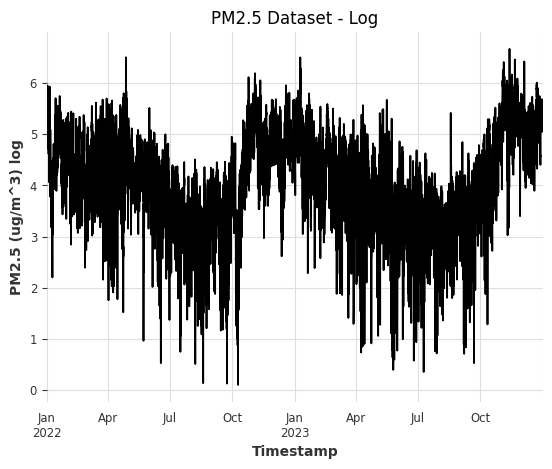

In [ ]:
df = pd.read_csv('combined_interplolated_IGI_airport.csv')
df = df.set_index('Timestamp')
df.index = pd.to_datetime(df.index)
print(df)
df_new = df['PM2.5 (µg/m³)']
print(df_new)
df_new.plot(label="values")
plt.title("PM2.5 Dataset")
plt.ylabel("PM2.5 (ug/m^3)")
plt.show()
# pre-processing to avoid negative valued forecasts
df_log = np.log(df_new + 1)
print(df_log)
df_log.plot(label="logged values")
plt.title("PM2.5 Dataset - Log")
plt.ylabel("PM2.5 (ug/m^3) log")
plt.show()

# Local Forecasting Models


## NaiveMean


In [ ]:
from darts.models import NaiveMean
model = NaiveMean()

0


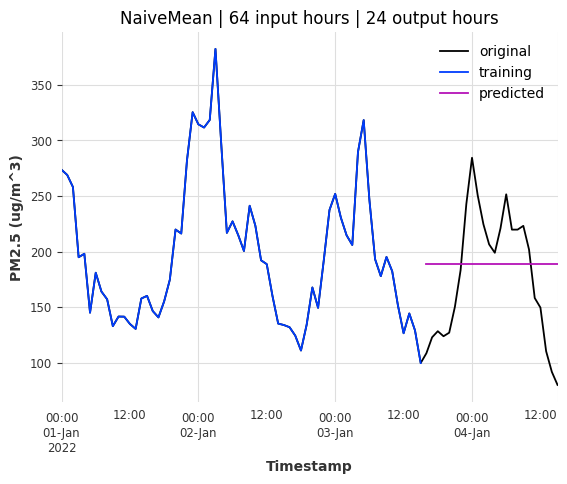

mae for this run : 50.38166666666666
1000


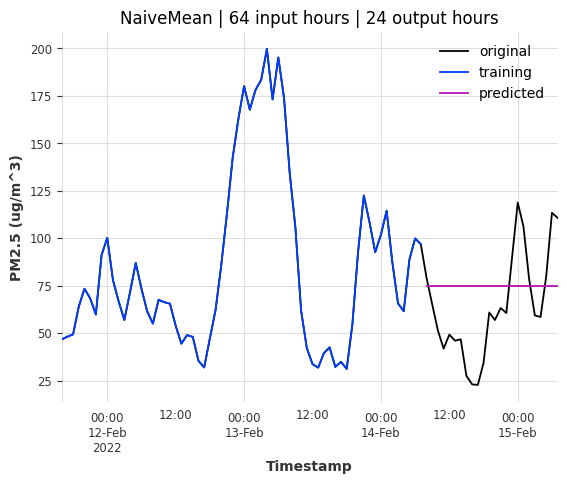

mae for this run : 25.281025091181395
2000


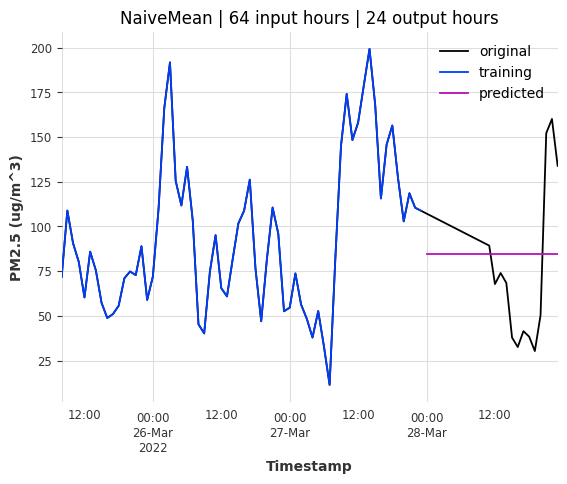

mae for this run : 28.185121157437894
3000


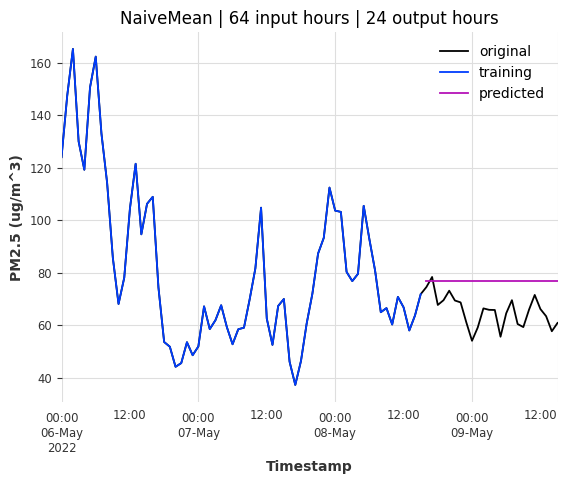

mae for this run : 11.569058611503275
4000


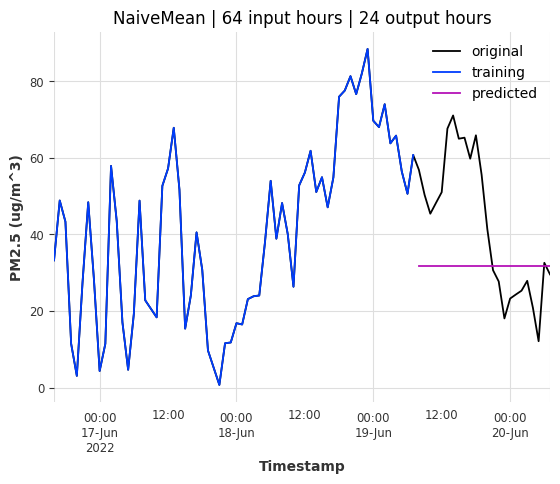

mae for this run : 17.066776616626402
5000


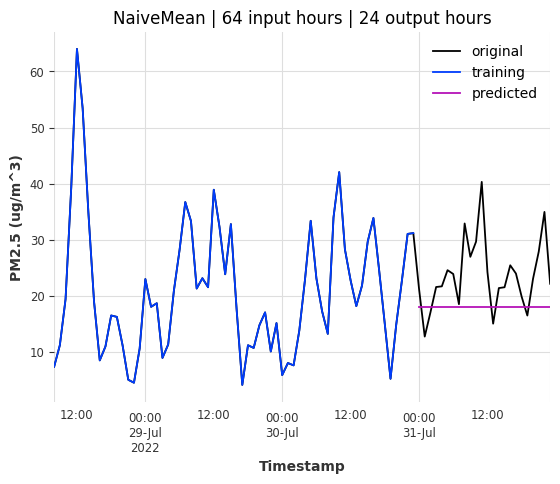

mae for this run : 6.546347465275537
6000


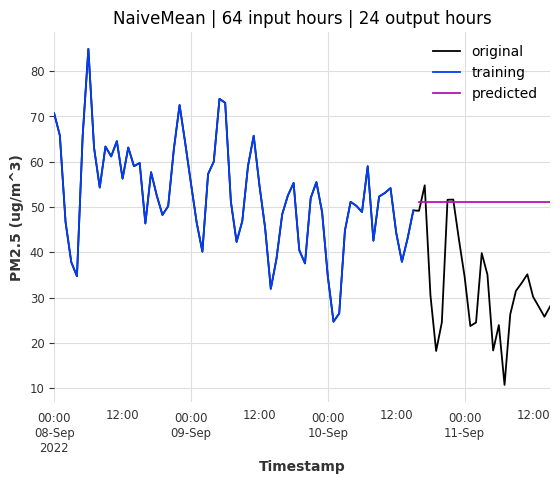

mae for this run : 19.28973431383823
7000


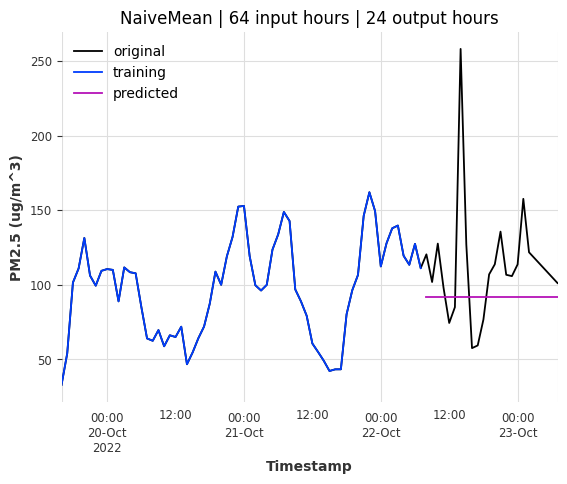

mae for this run : 29.312331522218898
8000


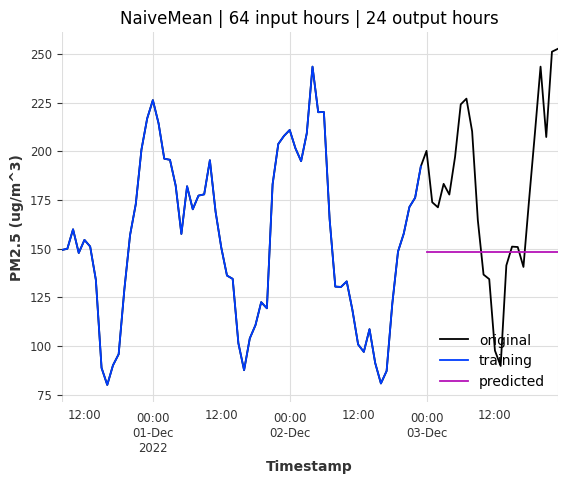

mae for this run : 43.76942732643303
9000


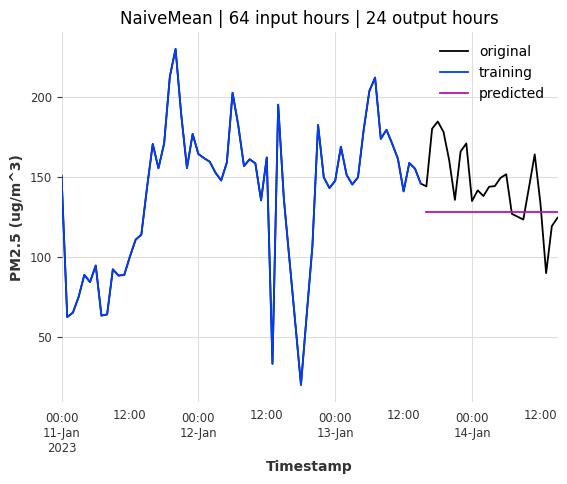

mae for this run : 21.556074791029545
10000


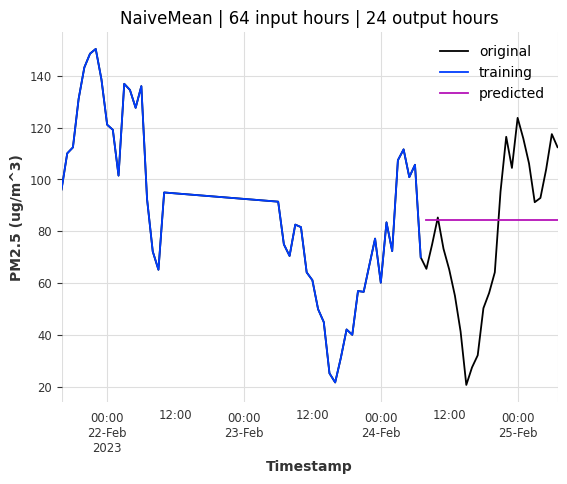

mae for this run : 26.608374999999995
11000


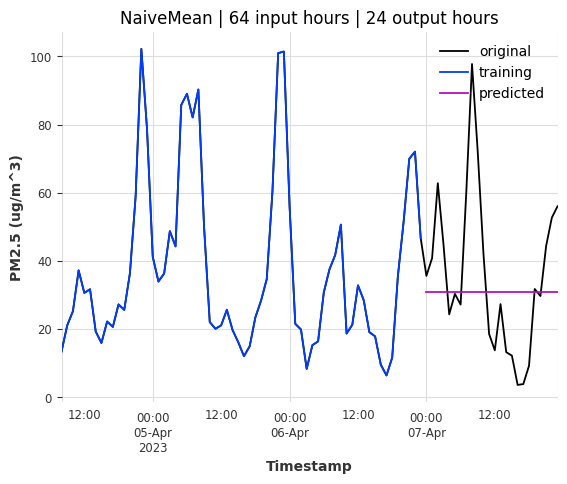

mae for this run : 17.826500000000003
12000


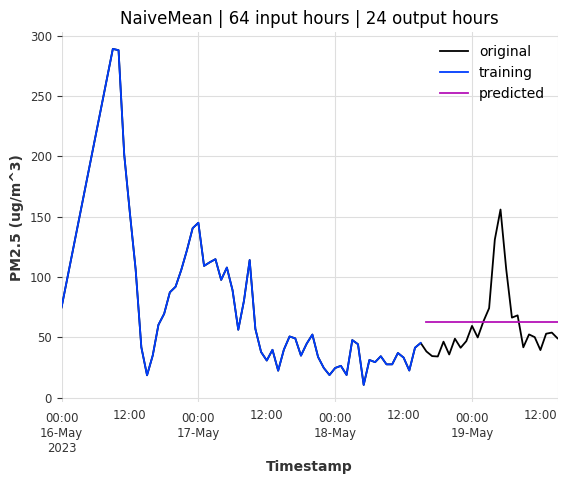

mae for this run : 21.478840988052468
13000


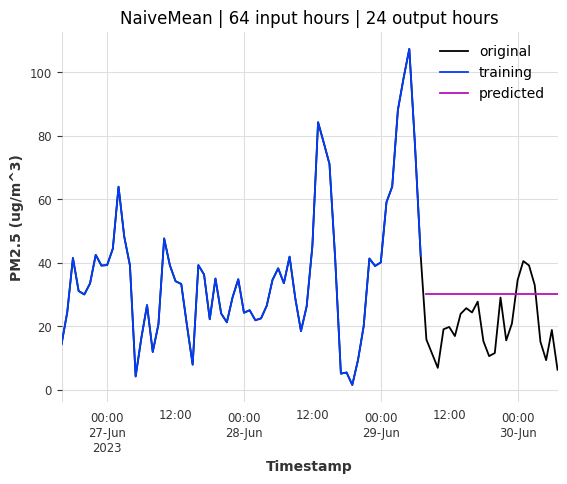

mae for this run : 11.841593096812773
14000


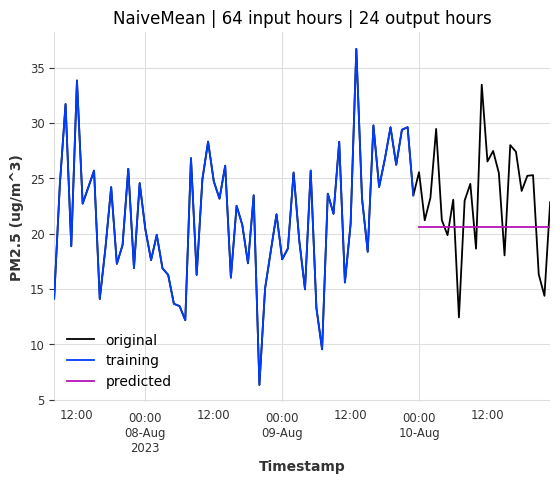

mae for this run : 4.595998557397164
15000


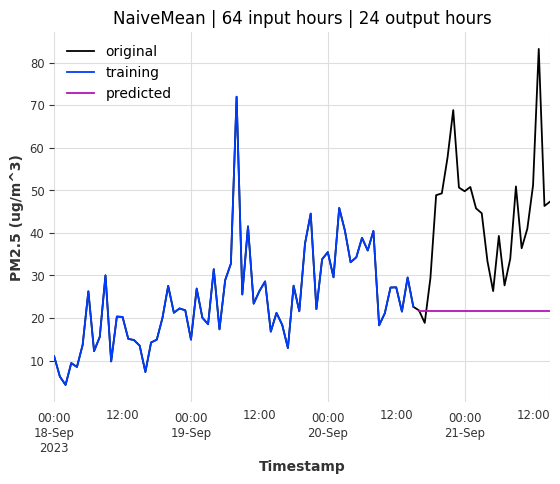

mae for this run : 22.50546162955006
16000


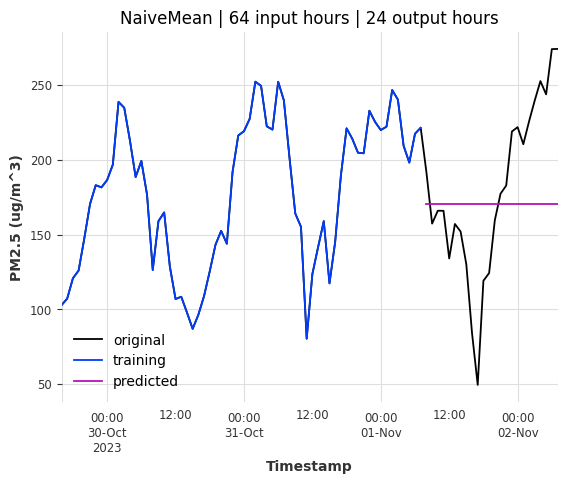

mae for this run : 46.447708333333345
17000


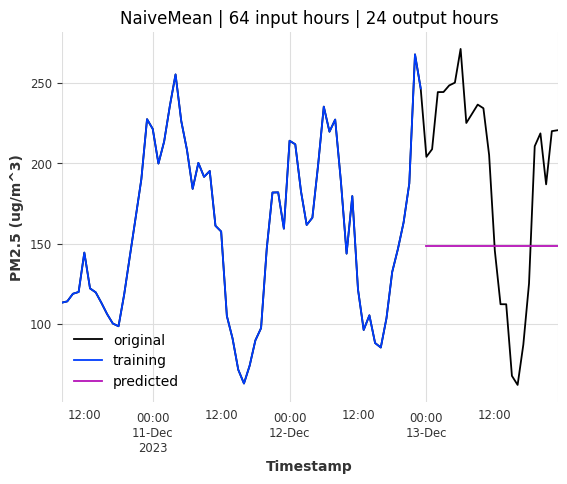

mae for this run : 69.29066136614834
[50.38166666666666, 25.281025091181395, 28.185121157437894, 11.569058611503275, 17.066776616626402, 6.546347465275537, 19.28973431383823, 29.312331522218898, 43.76942732643303, 21.556074791029545, 26.608374999999995, 17.826500000000003, 21.478840988052468, 11.841593096812773, 4.595998557397164, 22.50546162955006, 46.447708333333345, 69.29066136614834]
Overall MAE: 26.308483474083612


In [ ]:
inputhours = 64
outputhours = 24
mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    plt.title("NaiveMean | 64 input hours | 24 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    ax.legend()
    filename = f"nm-64-24-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
    # print(metrics.ae(pd.Series(current_chunk), pred_new, intersect=True))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")

## Naive Moving Average

In [ ]:
from darts.models import NaiveMovingAverage
model = NaiveMovingAverage(input_chunk_length = 24)


0


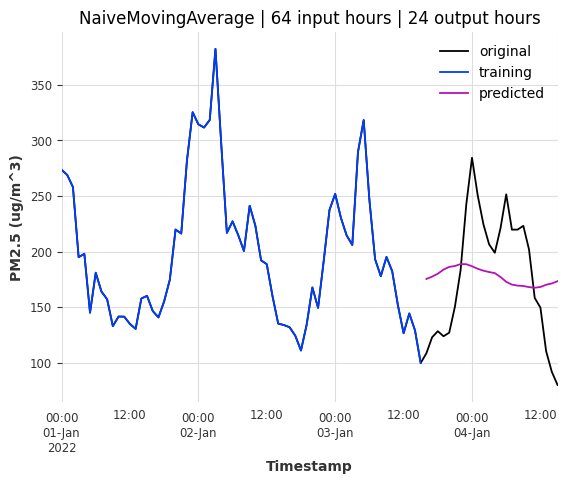

mae for this run : 50.277161280538145
1000


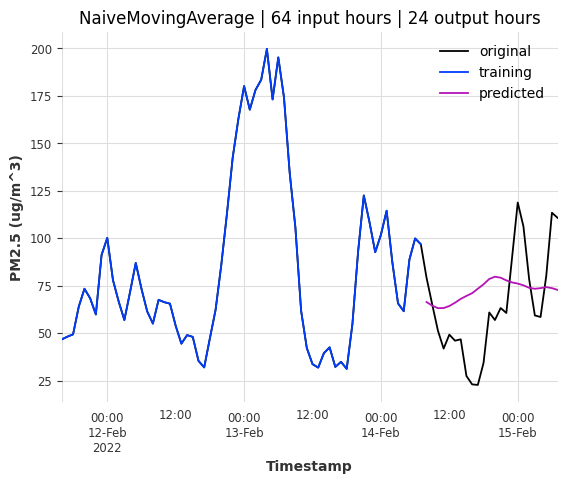

mae for this run : 23.465821095931705
2000


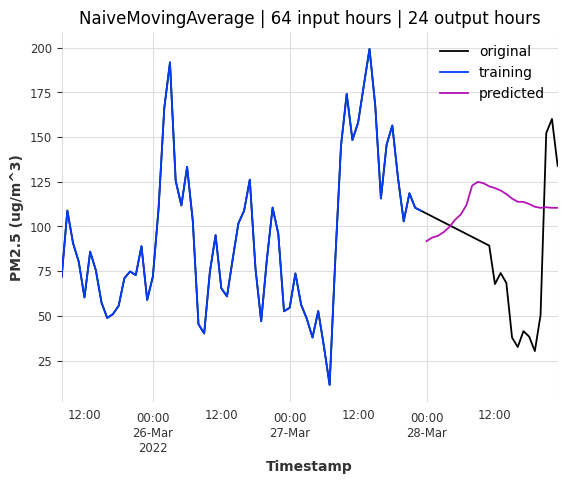

mae for this run : 37.942324550862644
3000


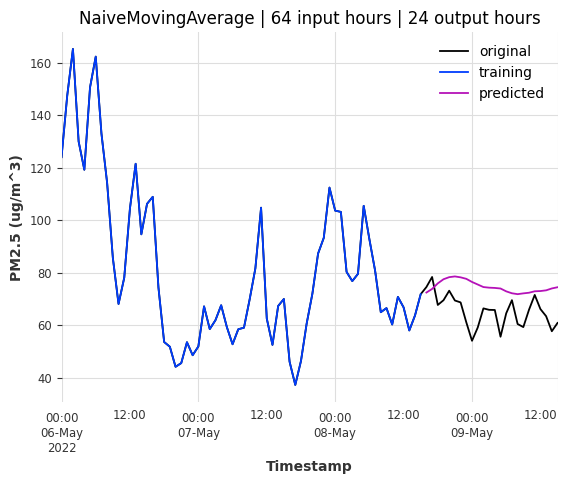

mae for this run : 9.80370655302624
4000


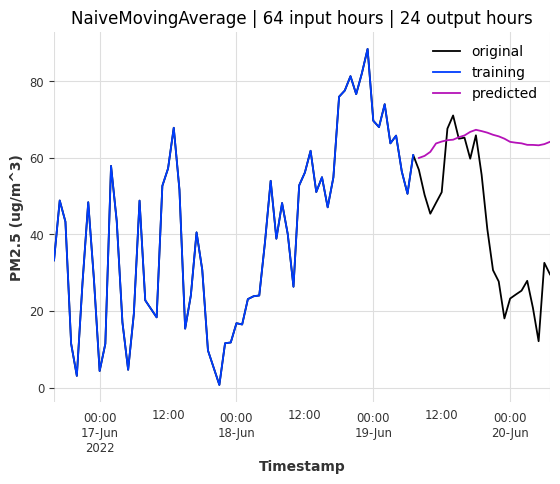

mae for this run : 22.820480651322715
5000


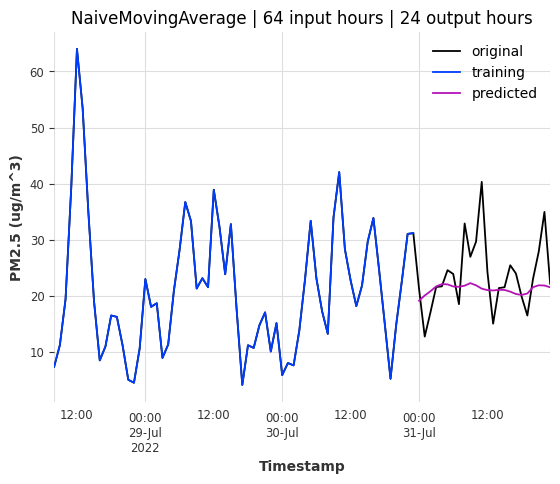

mae for this run : 4.49409237238775
6000


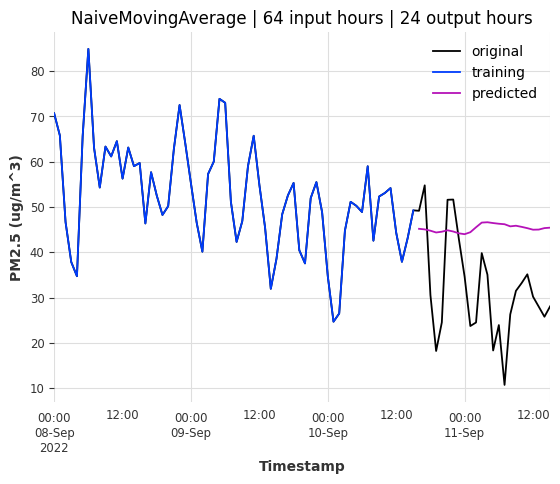

mae for this run : 15.404451268413572
7000


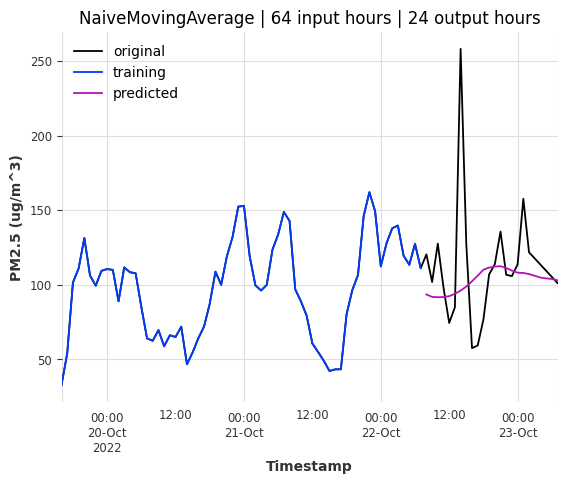

mae for this run : 23.23584789652571
8000


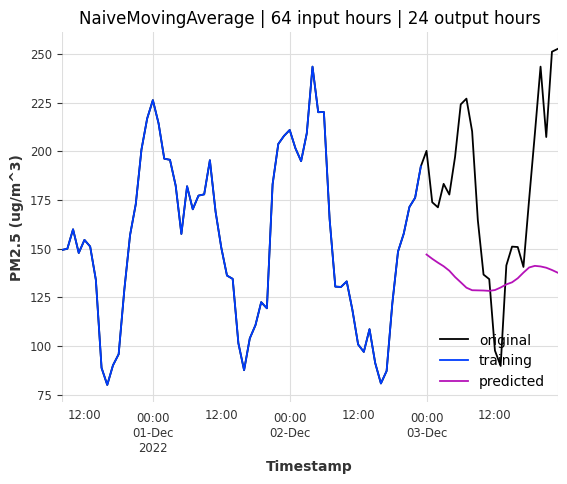

mae for this run : 49.678910724562435
9000


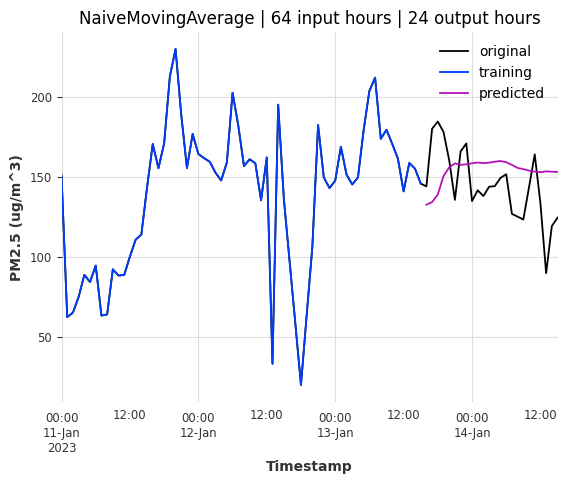

mae for this run : 22.842285365871607
10000


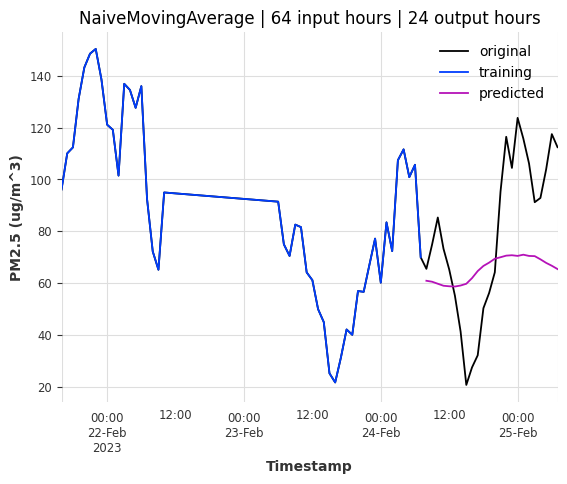

mae for this run : 26.77985921202502
11000


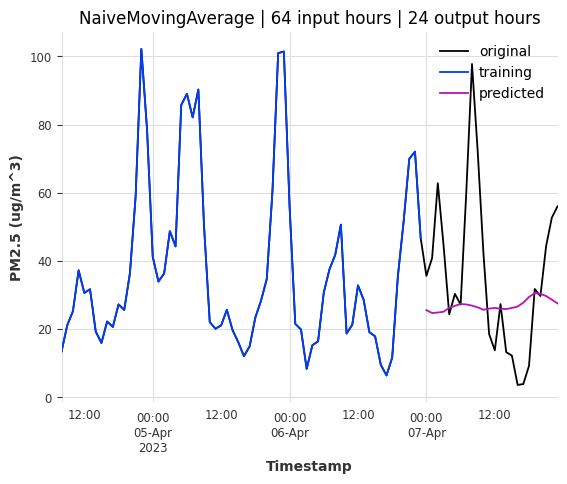

mae for this run : 18.318239028866397
12000


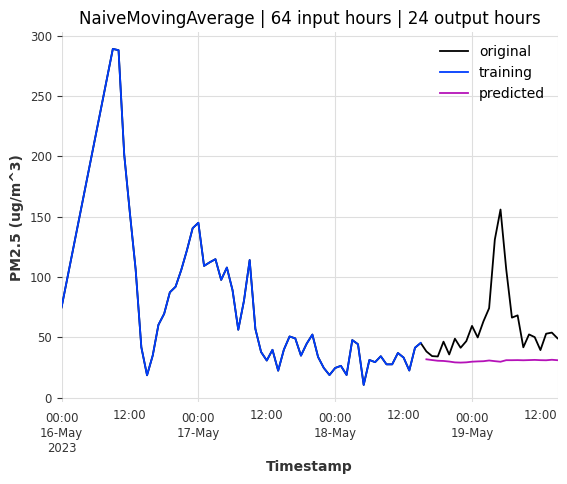

mae for this run : 29.460510327455804
13000


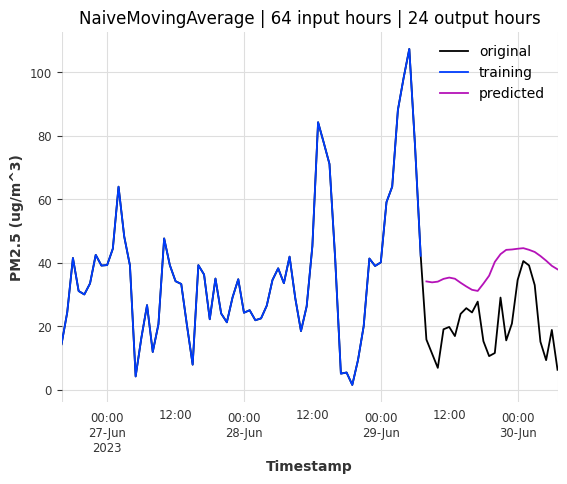

mae for this run : 17.566038623736333
14000


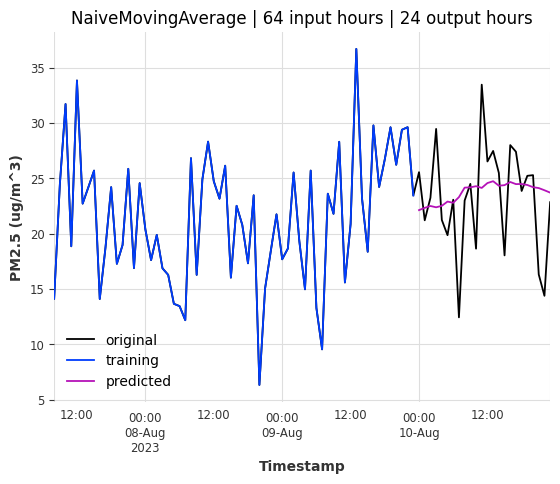

mae for this run : 3.4773012718225047
15000


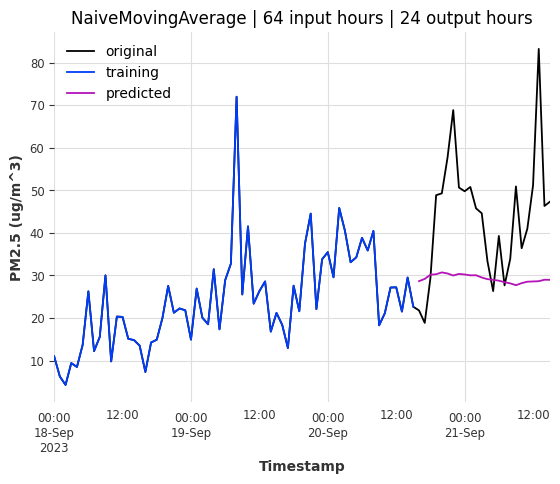

mae for this run : 16.391464723336465
16000


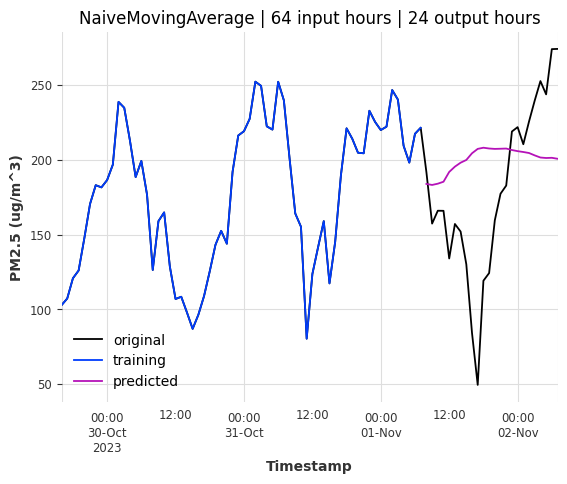

mae for this run : 48.679855680657816
17000


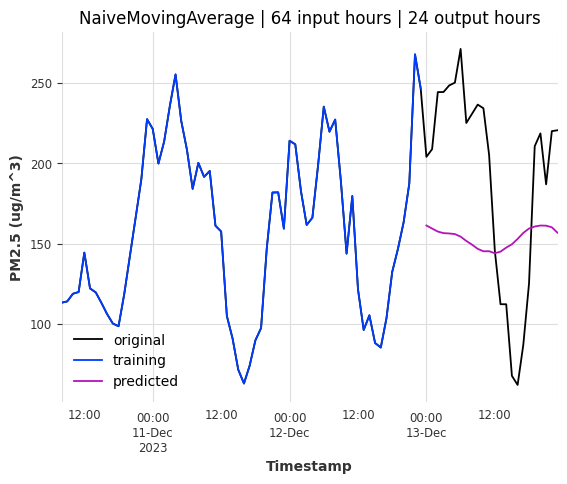

mae for this run : 65.39280819001144
[50.277161280538145, 23.465821095931705, 37.942324550862644, 9.80370655302624, 22.820480651322715, 4.49409237238775, 15.404451268413572, 23.23584789652571, 49.678910724562435, 22.842285365871607, 26.77985921202502, 18.318239028866397, 29.460510327455804, 17.566038623736333, 3.4773012718225047, 16.391464723336465, 48.679855680657816, 65.39280819001144]
Overall MAE: 27.00173104540857


In [ ]:

mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    ax.legend()
    plt.title("NaiveMovingAverage | 64 input hours | 24 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    filename = f"nma-64-24-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
    # print(metrics.ae(pd.Series(current_chunk), pred_new, intersect=True))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")


# Statistical Models

## ARIMA

### Step 1 : Dickey-Fuller test for stationary check

If p-value is more than 0.05, then series is non-stationary.

In [ ]:
from darts.models import ARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from statsmodels.tsa.stattools import adfuller
%pip install pmdarima
from pmdarima.arima import auto_arima

0
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-19.590, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-27.921, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-35.214, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-44.604, Time=0.28 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-44.694, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-43.760, Time=0.15 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-45.519, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-45.721, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-44.414, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-44.254, Time=0.55 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-43.728, Time=0.30 

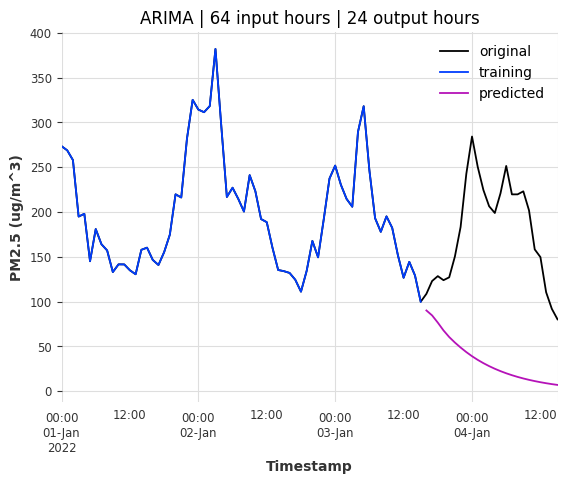

mae for this run : 143.68096961882978
1000
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-0.031, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=0.981, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-3.371, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-1.373, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.871 seconds
Best model order: p=0, d=2, q=1


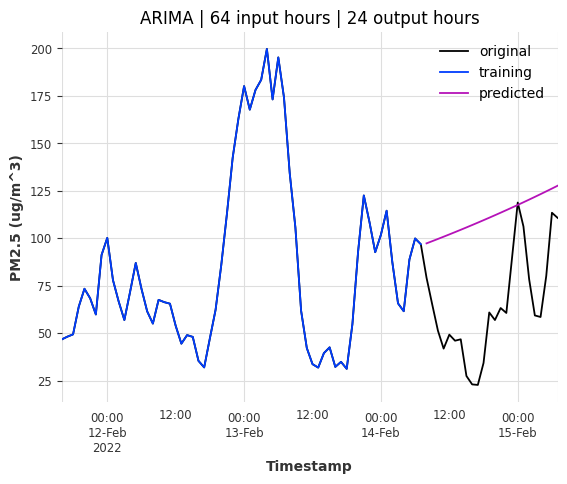

mae for this run : 47.63468333530995
2000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=67.055, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.053, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.045, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=65.072, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.523 seconds
Best model order: p=0, d=1, q=0


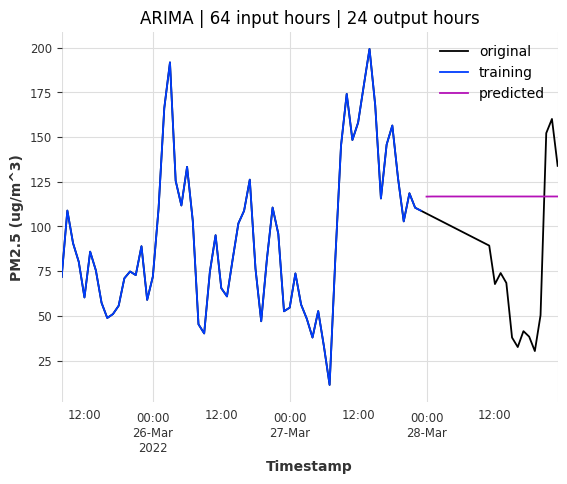

mae for this run : 38.64633123419432
3000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29.107, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.401, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28.147, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30.300, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30.268, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-30.904, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-32.559, Time=0.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-33.005, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-31.419, Time=0.75 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-34.115, Time=2.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-29.422, Time=1.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-34.230, Time=2.65 sec
 ARIMA(1,1,3)

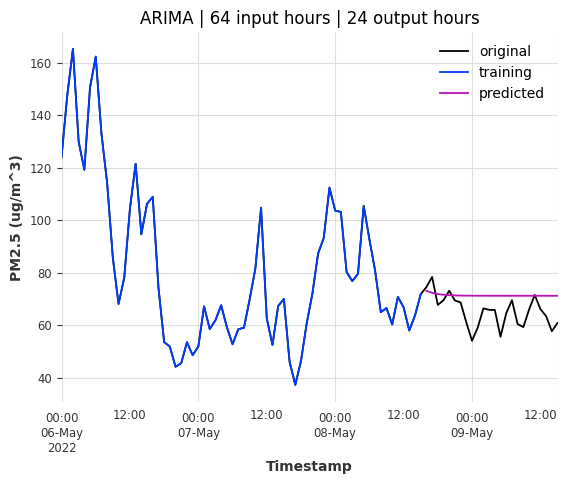

mae for this run : 6.837286560722558
4000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.194, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=139.174, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=137.385, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135.206, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.001 seconds
Best model order: p=0, d=1, q=0


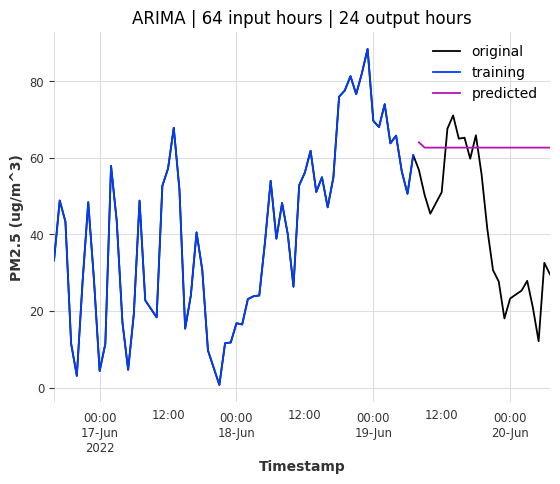

mae for this run : 22.199706053283023
5000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=92.745, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=89.508, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90.956, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=90.816, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=87.634, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.699 seconds
Best model order: p=0, d=1, q=0


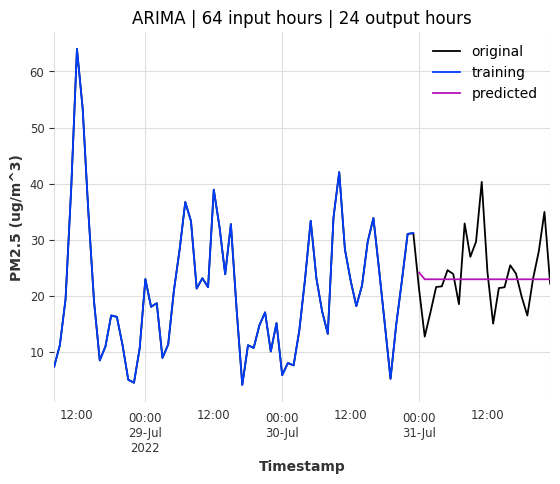

mae for this run : 4.571925198127069
6000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-34.201, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1.693, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-27.253, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-30.523, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=359.751, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-37.027, Time=2.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-38.987, Time=0.55 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-37.078, Time=0.60 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-34.987, Time=1.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 5.693 seconds
Best model order: p=2, d=0, q=0


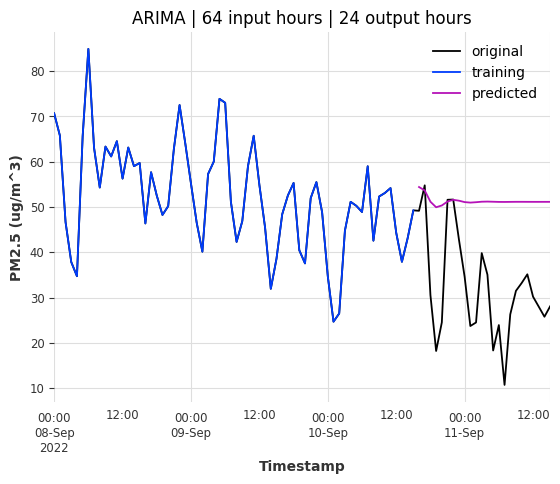

mae for this run : 19.271255436318302
7000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21.829, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20.313, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23.629, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-22.662, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21.743, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21.947, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-20.077, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-25.248, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-23.564, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-23.449, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24.241, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21.693, Time=0.23 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.374 seconds
Best model order: p=1, d=1, q=0


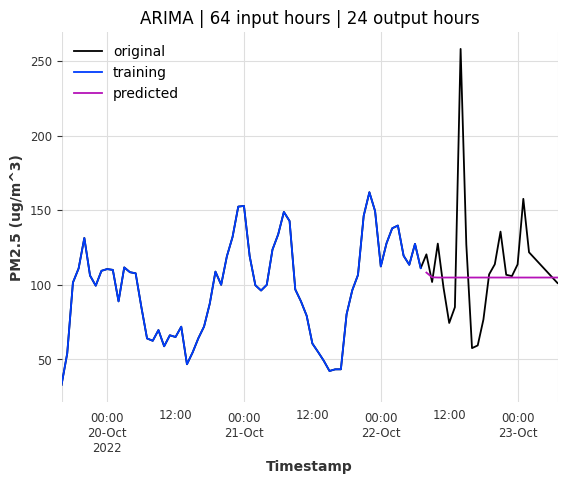

mae for this run : 22.7133838011482
8000
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-46.448, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-50.314, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-56.624, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-54.664, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.026 seconds
Best model order: p=0, d=2, q=1


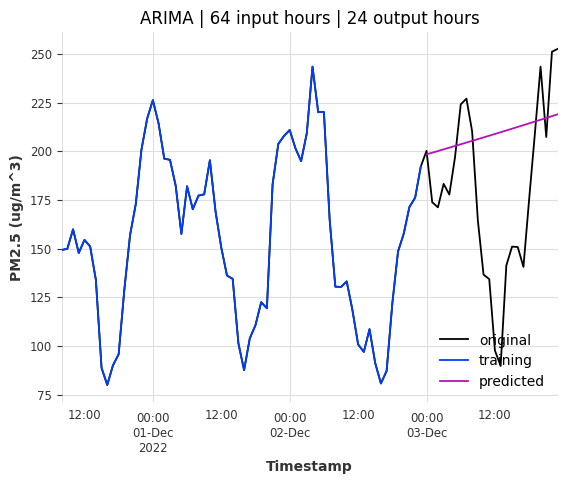

mae for this run : 40.93012569461691
9000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.191, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.396, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.622, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=62.080, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68.396, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=62.782, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=60.175, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=60.523, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=60.952, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=63.629, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.474 seconds
Best model order: p=0, d=1, q=1


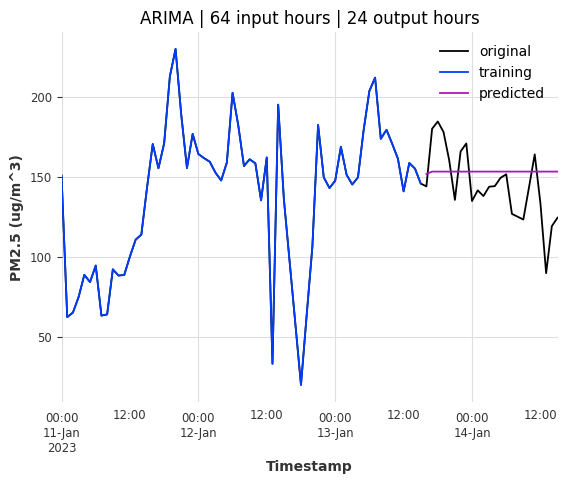

mae for this run : 19.42045505635532
10000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-32.017, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36.015, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-34.039, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-34.036, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-37.965, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
Best model order: p=0, d=1, q=0


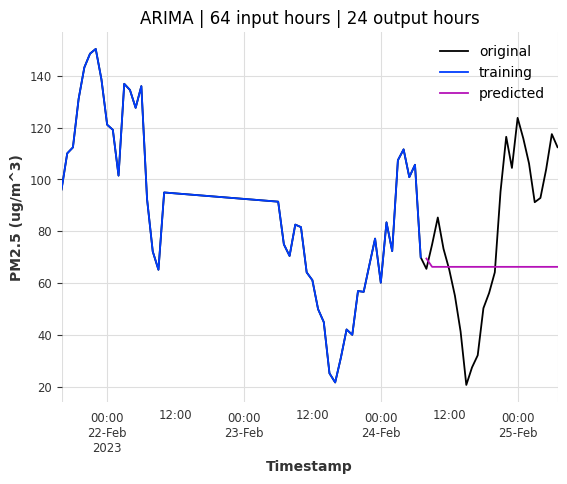

mae for this run : 28.043956118445465
11000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.065, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=124.717, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=67.581, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=81.832, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=344.625, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.289, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=56.785, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=57.767, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=57.683, Time=0.67 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=59.818, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=55.768, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=57.766, Time=0.33 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=59.764, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=74.863, Time=0.29 sec

Best model:  A

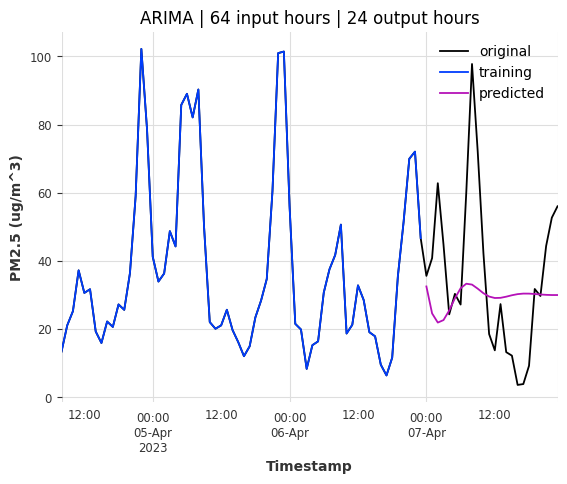

mae for this run : 18.111016592375822
12000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=66.803, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.484, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68.279, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64.828, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.863 seconds
Best model order: p=0, d=1, q=0


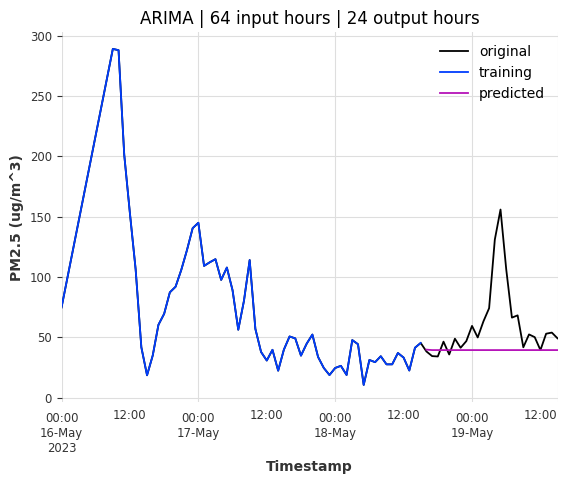

mae for this run : 21.864980939260274
13000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=109.291, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=139.379, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=108.260, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=114.775, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=344.233, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=108.937, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=101.288, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=102.773, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=103.218, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=111.029, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=109.638, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=125.822, Time=0.09 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 2.320 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


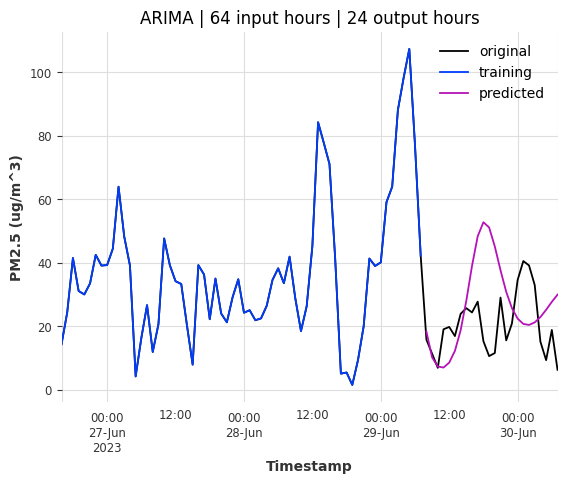

mae for this run : 13.905813415691838
14000
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31.715, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=58.554, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44.094, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29.740, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56.580, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=31.717, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=27.944, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.930, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=29.931, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=42.143, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.328 seconds
Best model order: p=0, d=1, q=1


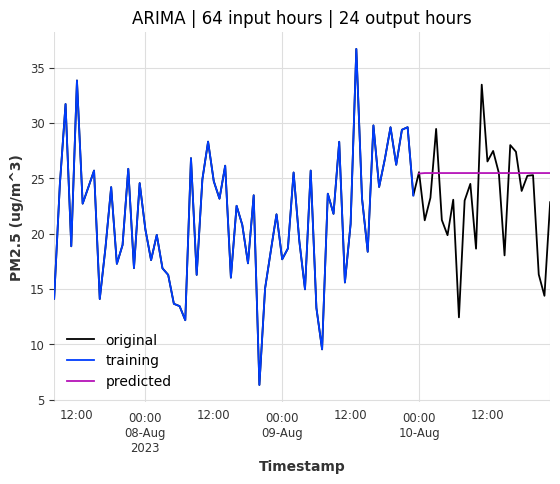

mae for this run : 3.918824175981005
15000
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=58.665, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=91.918, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=65.559, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=77.474, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=330.703, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=59.334, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=57.712, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=66.860, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=59.712, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=58.361, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=56.439, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=58.401, Time=0.15 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=57.022, Time=0.38 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(

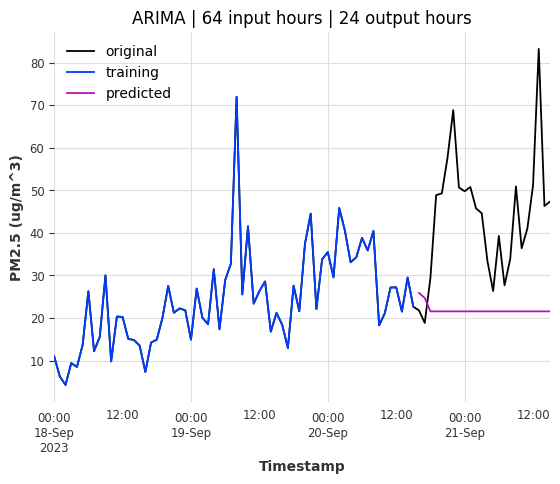

mae for this run : 22.84894930315107
16000
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-4.350, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-16.912, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-23.069, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-39.656, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-37.740, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-37.820, Time=0.35 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.51 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-37.698, Time=0.36 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 3.681 seconds
Best model order: p=3, d=2, q=0


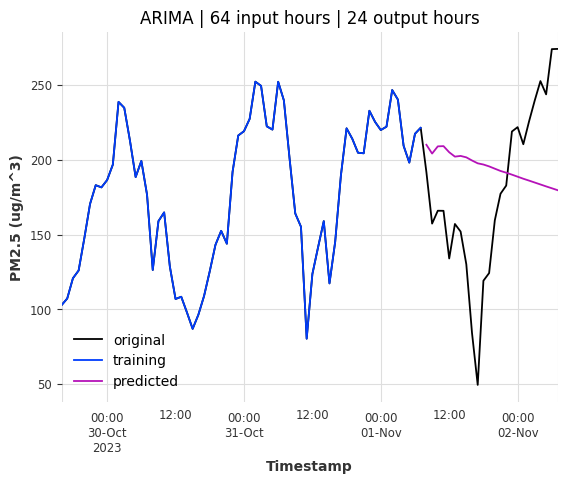

mae for this run : 56.63392133281087
17000
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-17.902, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-29.273, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-37.538, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-35.589, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.096 seconds
Best model order: p=0, d=2, q=1


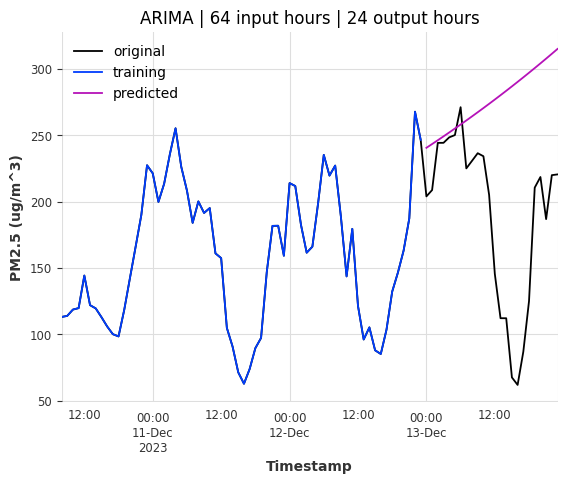

mae for this run : 86.9705672765631
[143.68096961882978, 47.63468333530995, 38.64633123419432, 6.837286560722558, 22.199706053283023, 4.571925198127069, 19.271255436318302, 22.7133838011482, 40.93012569461691, 19.42045505635532, 28.043956118445465, 18.111016592375822, 21.864980939260274, 13.905813415691838, 3.918824175981005, 22.84894930315107, 56.63392133281087, 86.9705672765631]
Overall MAE: 34.344675063510266


In [ ]:

mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    adfuller(current_chunk)
    ts = TimeSeries.from_series(input_series)

    model = auto_arima(input_df, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,


                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
    p, d, q = model.order
    print(f"Best model order: p={p}, d={d}, q={q}")
    model2 = ARIMA(p = p, d = d, q = 2)
    model2.fit(ts)
    pred = model2.predict(outputhours)
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    ax.legend()
    plt.title("ARIMA | 64 input hours | 24 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    filename = f"arima-64-24-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
    # print(metrics.ae(pd.Series(current_chunk), pred_new, intersect=True))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")

In [ ]:
from darts.models import AutoARIMA
model = AutoARIMA(start_p=8, max_p=12, start_q=1)

0


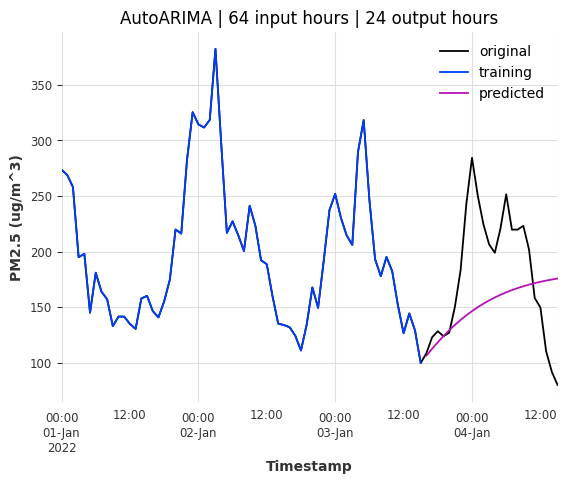

mae for this run : 50.22738319788823
1000


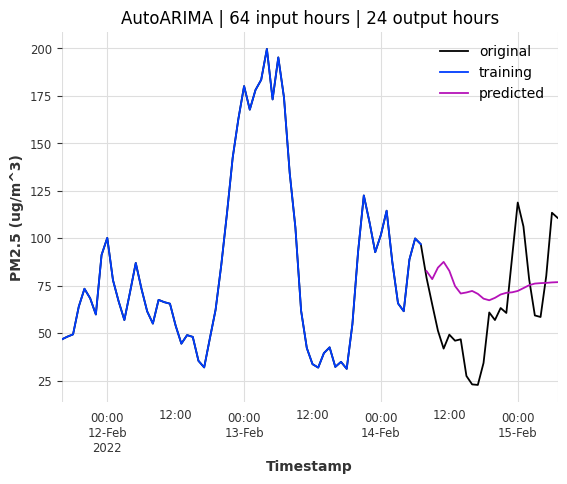

mae for this run : 25.11265741176909
2000


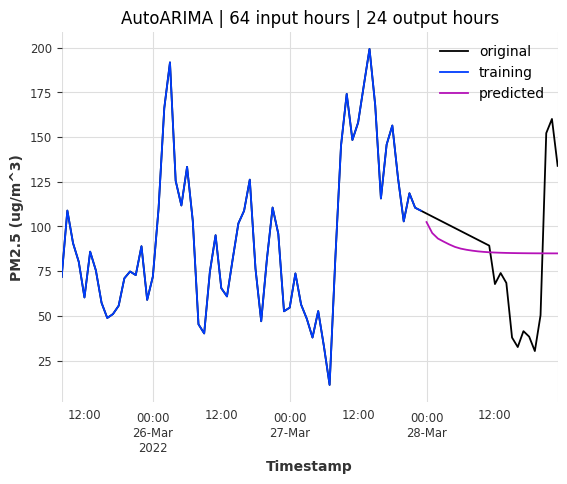

mae for this run : 25.612293938147925
3000


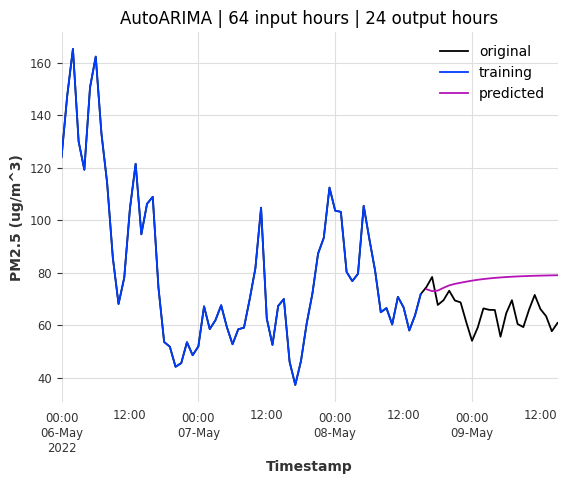

mae for this run : 12.296525290872639
4000


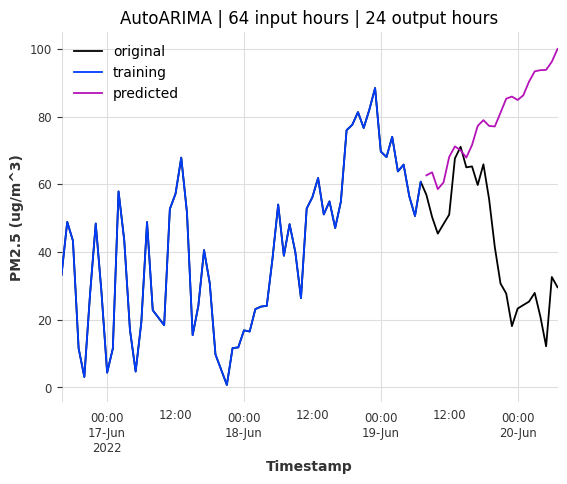

mae for this run : 36.74404433885949
5000


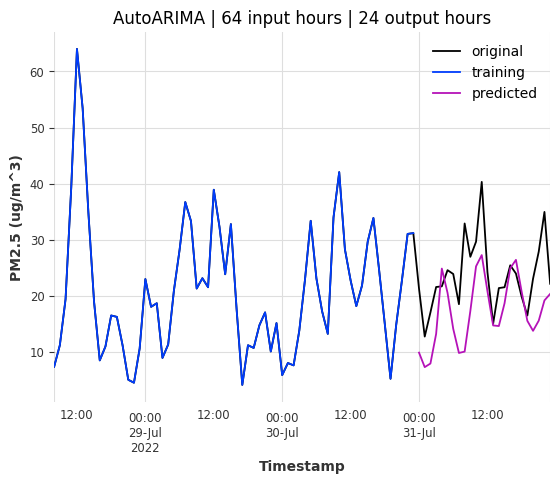

mae for this run : 6.963579453277803
6000


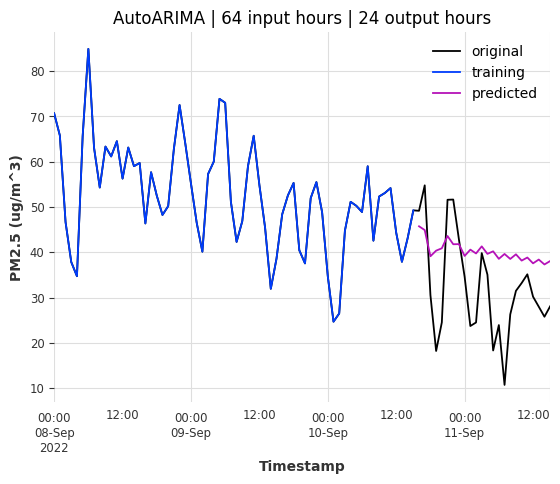

mae for this run : 10.653224663585382
7000


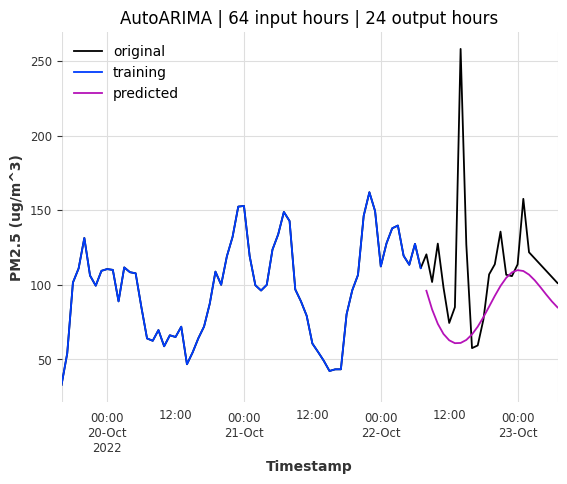

mae for this run : 28.236036951773873
8000


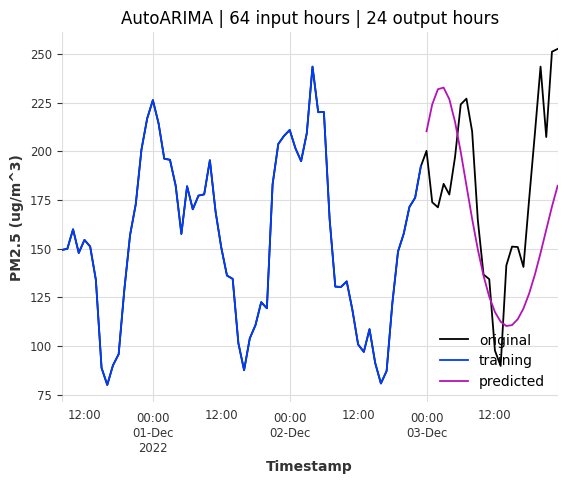

mae for this run : 40.109678850476264
9000


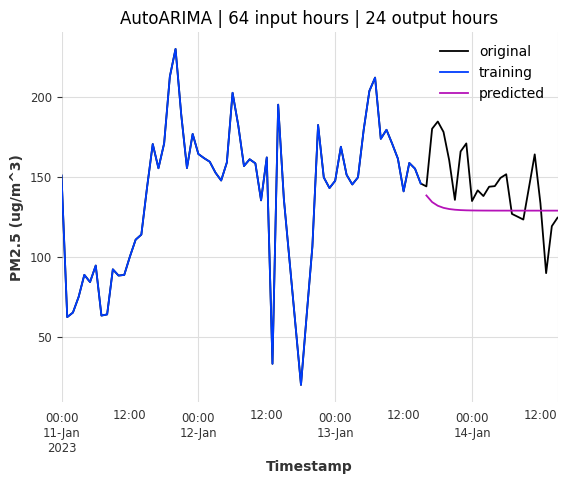

mae for this run : 20.26185637282727
10000


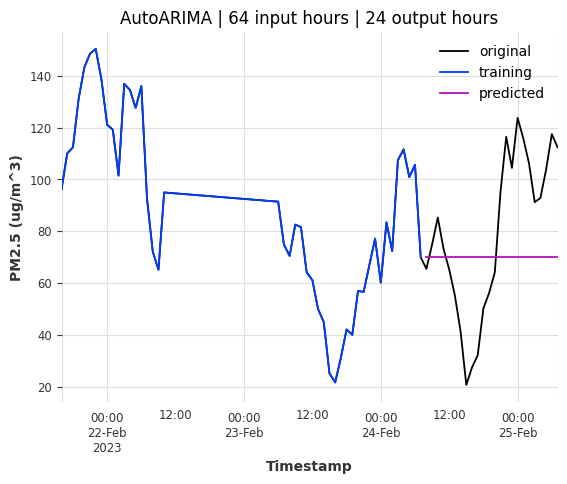

mae for this run : 27.29354166666666
11000


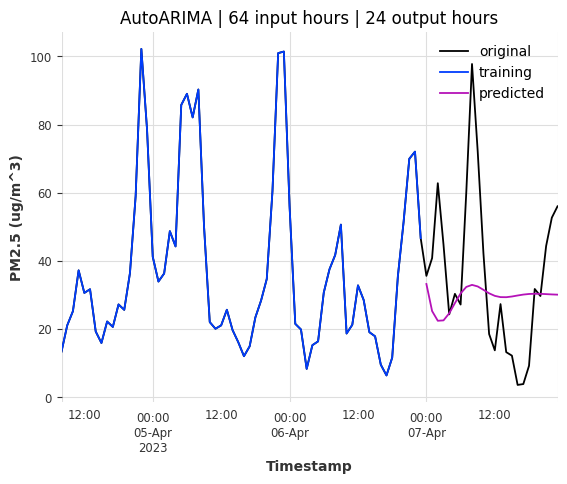

mae for this run : 17.9742769318522
12000


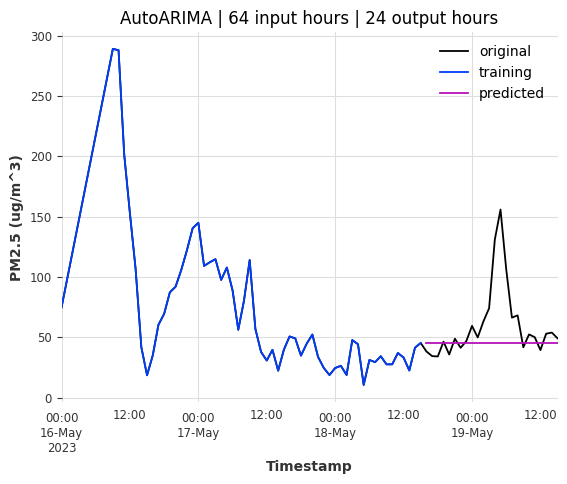

mae for this run : 19.030791666666662
13000


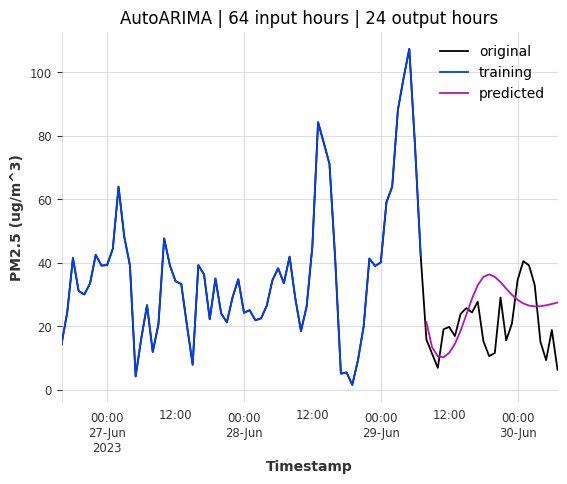

mae for this run : 10.184622541703908
14000


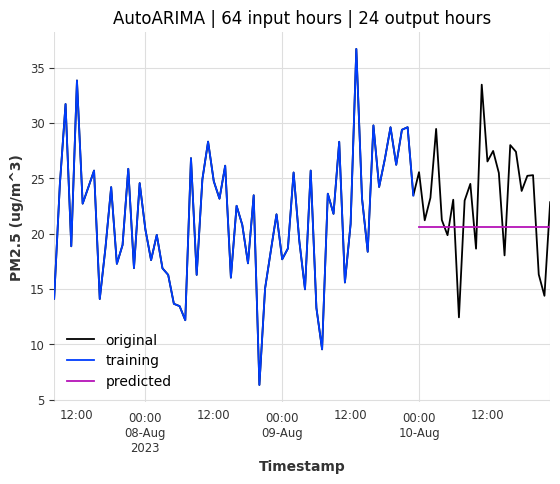

mae for this run : 4.595998558821861
15000


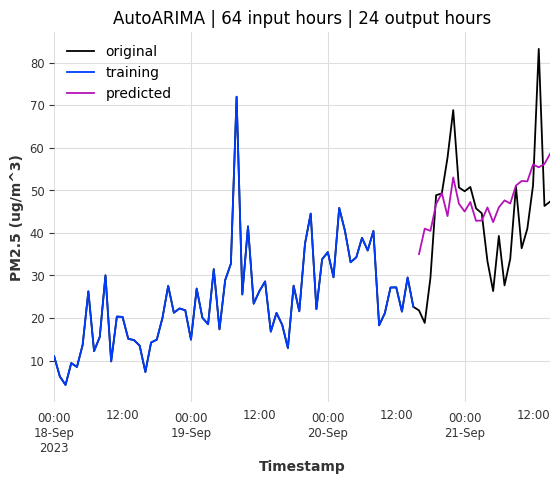

mae for this run : 10.183721627194204
16000


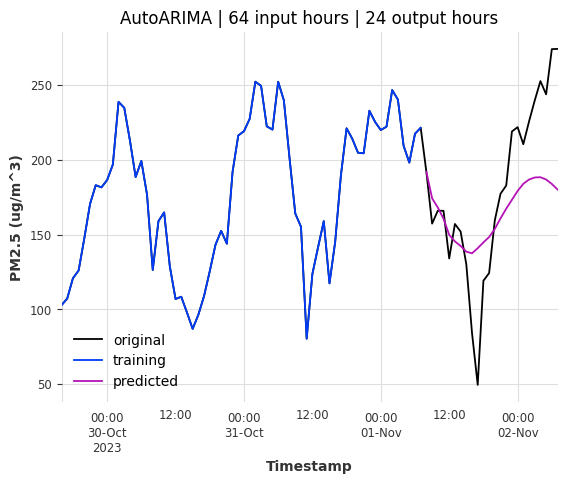

mae for this run : 33.88743232339478
17000


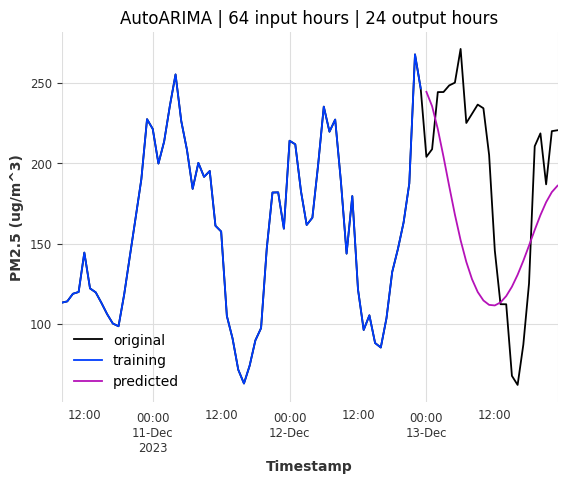

mae for this run : 55.941455638280075
[50.22738319788823, 25.11265741176909, 25.612293938147925, 12.296525290872639, 36.74404433885949, 6.963579453277803, 10.653224663585382, 28.236036951773873, 40.109678850476264, 20.26185637282727, 27.29354166666666, 17.9742769318522, 19.030791666666662, 10.184622541703908, 4.595998558821861, 10.183721627194204, 33.88743232339478, 55.941455638280075]
Overall MAE: 24.183840079114347


In [ ]:

mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]


    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)


    # Extract p, d, q values




    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    ax.legend()
    plt.title("AutoARIMA | 64 input hours | 24 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    filename = f"autoarima-64-24-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")


In [ ]:
from darts.models import Theta
model = Theta(theta = 2)

0


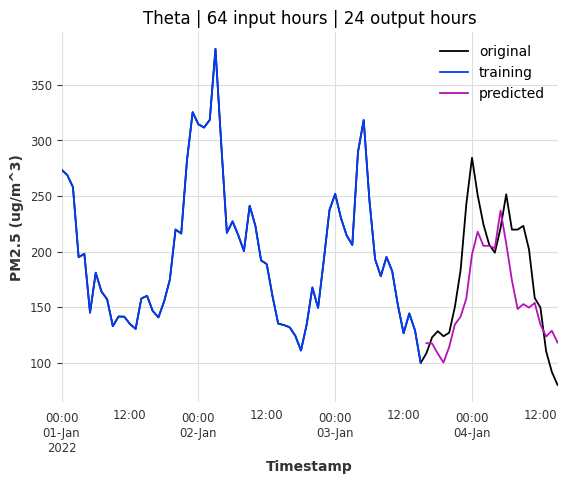

mae for this run : 31.88713117879783
1000


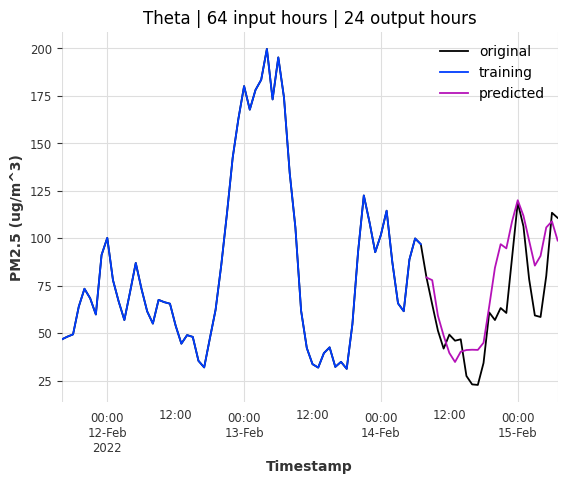

mae for this run : 15.05922956773862
2000


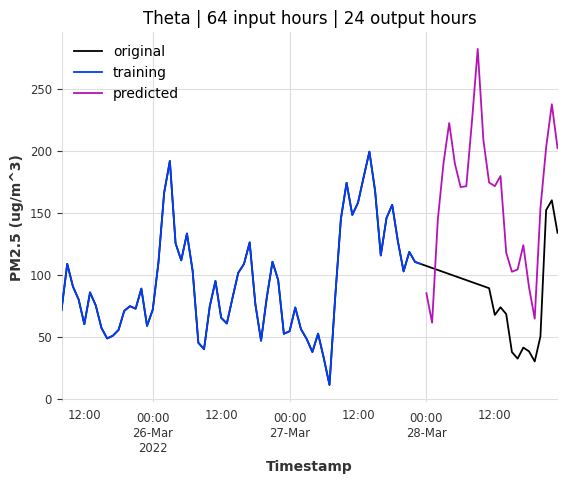

mae for this run : 80.84609167708209
3000


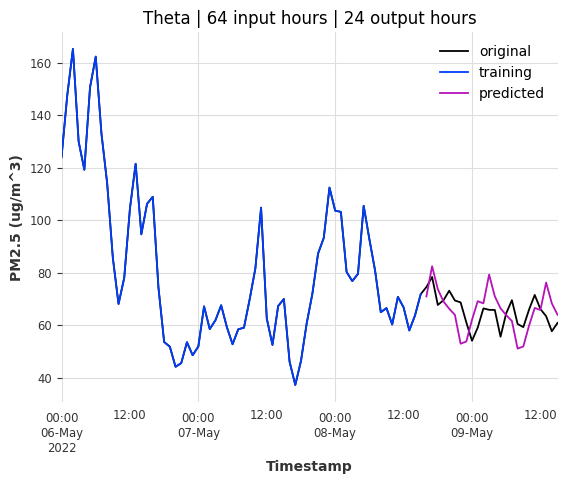

mae for this run : 6.770976840732541
4000


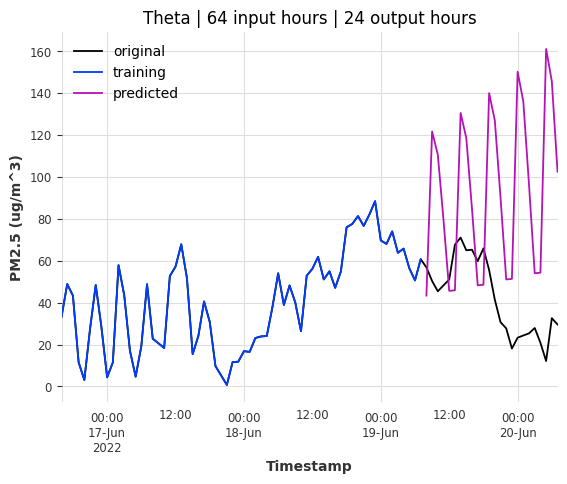

mae for this run : 56.698812324428154
5000


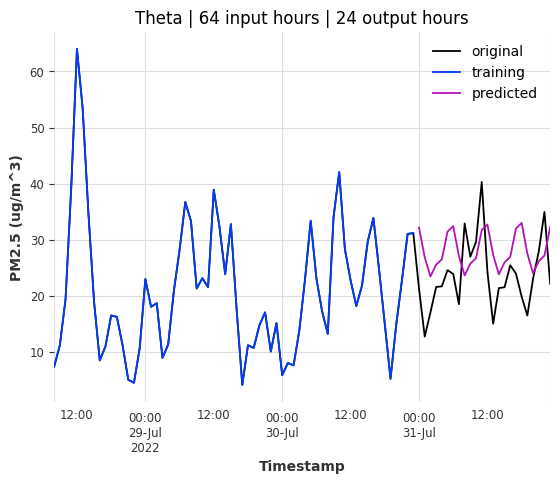

mae for this run : 6.998420292377214
6000


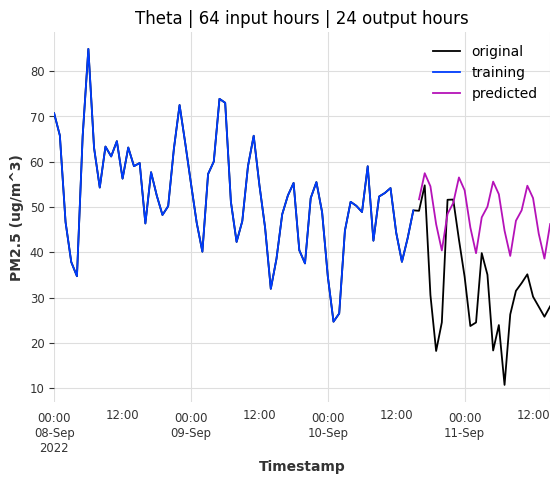

mae for this run : 16.779615674790247
7000


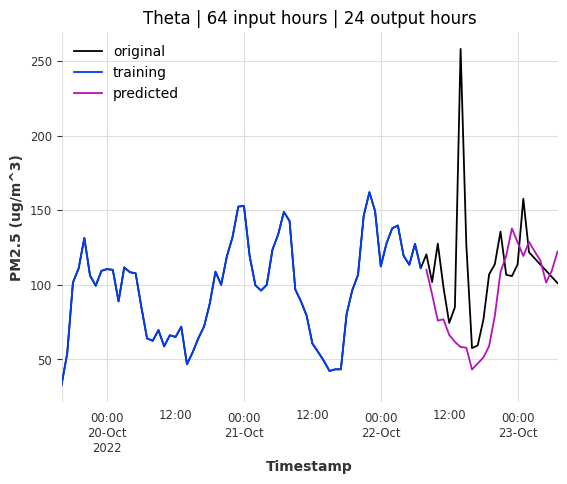

mae for this run : 29.13579003808668
8000


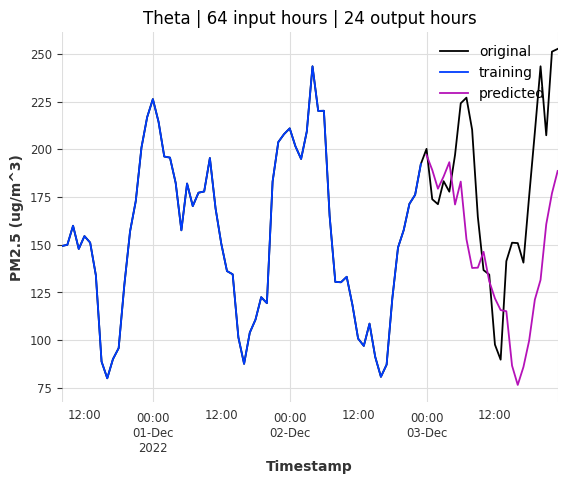

mae for this run : 42.83125815322222
9000


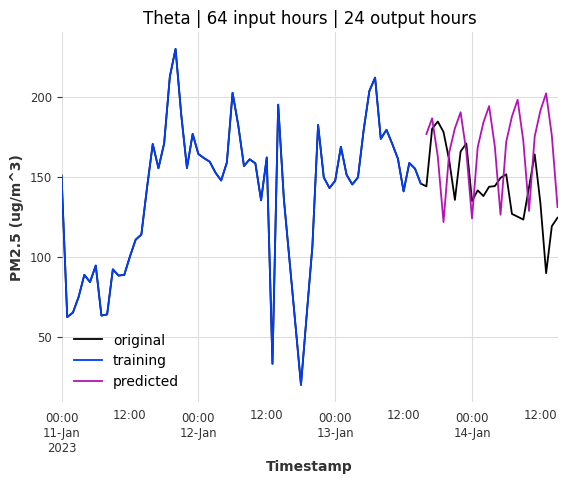

mae for this run : 35.058316752109135
10000


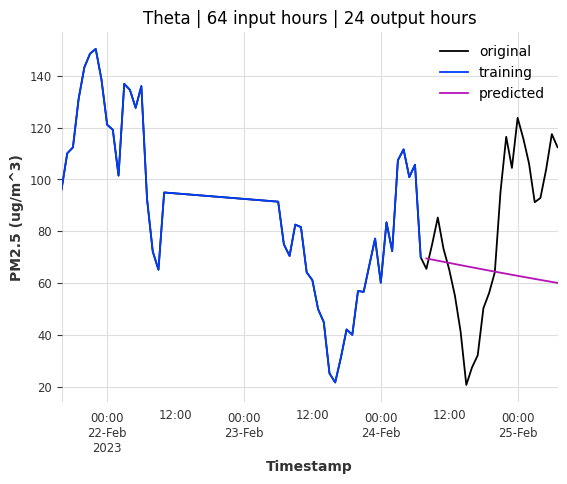

mae for this run : 29.62489543806765
11000


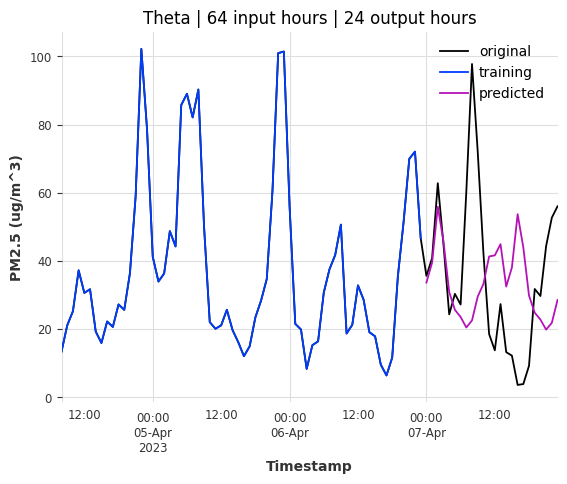

mae for this run : 21.389272598191084
12000


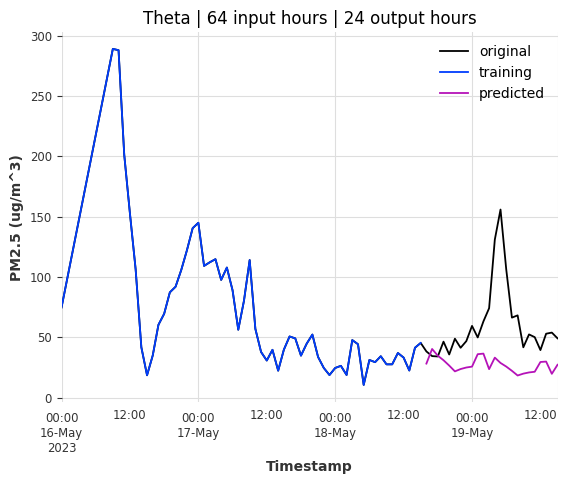

mae for this run : 33.468769114195176
13000


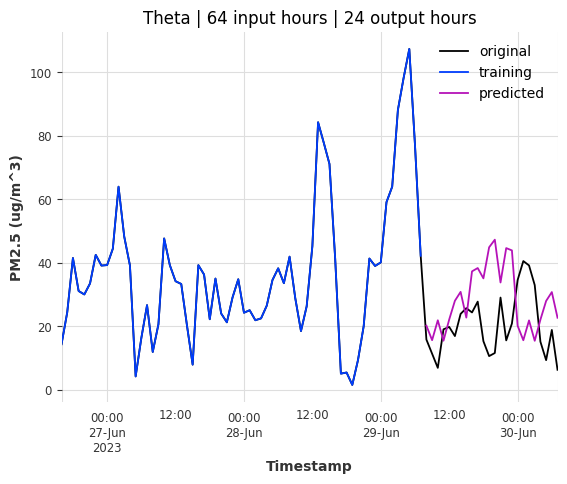

mae for this run : 14.532667294934067
14000


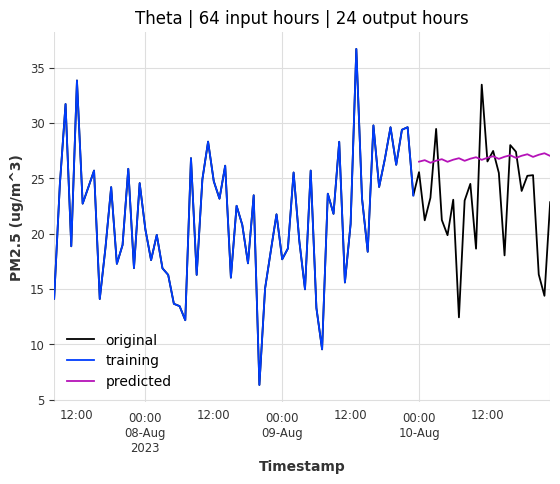

mae for this run : 4.60531659513823
15000


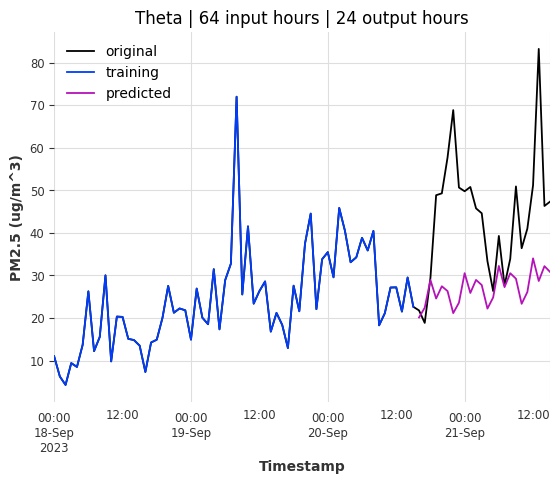

mae for this run : 17.14024139368708
16000


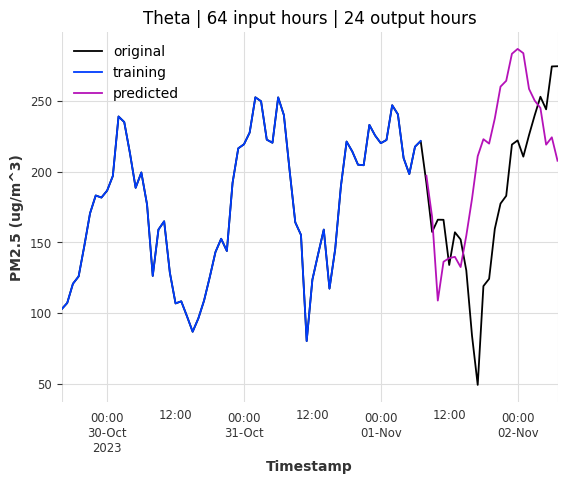

mae for this run : 52.55954444824409
17000


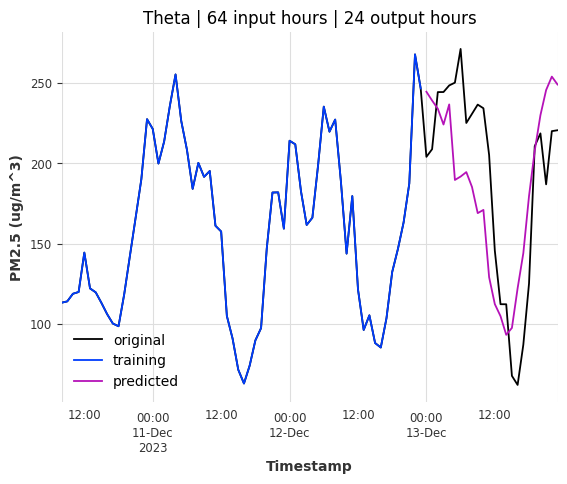

mae for this run : 38.931319765037465
[31.88713117879783, 15.05922956773862, 80.84609167708209, 6.770976840732541, 56.698812324428154, 6.998420292377214, 16.779615674790247, 29.13579003808668, 42.83125815322222, 35.058316752109135, 29.62489543806765, 21.389272598191084, 33.468769114195176, 14.532667294934067, 4.60531659513823, 17.14024139368708, 52.55954444824409, 38.931319765037465]
Overall MAE: 29.68431495260331


In [ ]:

mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    plt.title("Theta | 64 input hours | 24 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    ax.legend()
    filename = f"theta-64-24-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")

In [ ]:
from darts.models import Prophet
model = Prophet(country_holidays='IN')


/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/pkslss4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/7lc5k9kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5689', 'data', 'file=/tmp/tmp22xgl5if/pkslss4n.json', 'init=/tmp/tmp22xgl5if/7lc5k9kx.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_model2bql_ots/prophet_model-20240520142908.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:08 - cmdstanpy - INFO - Chain [1] start processing

0


14:29:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


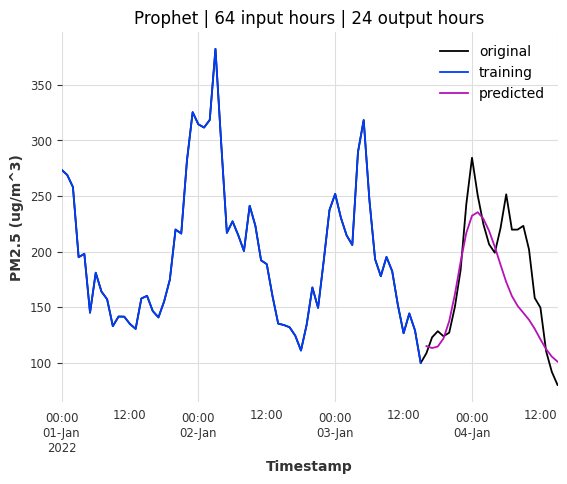

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/f7okclc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/zufhwvh3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72936', 'data', 'file=/tmp/tmp22xgl5if/f7okclc5.json', 'init=/tmp/tmp22xgl5if/zufhwvh3.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelu7tu96bj/prophet_model-20240520142909.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:09 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 27.093986474998484
1000


14:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


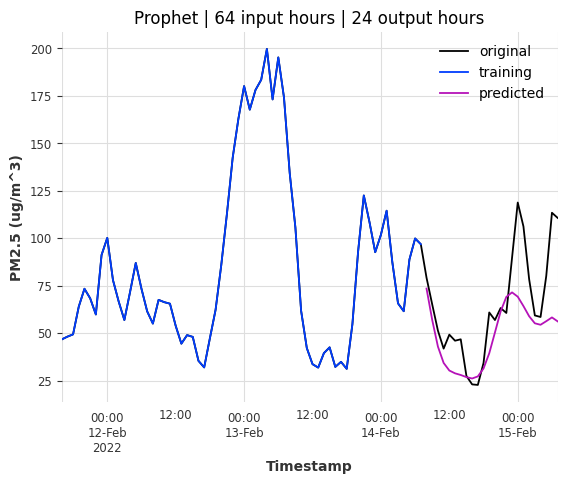

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/3d3cnlom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/i97ax5ks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60746', 'data', 'file=/tmp/tmp22xgl5if/3d3cnlom.json', 'init=/tmp/tmp22xgl5if/i97ax5ks.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_model2sav4a20/prophet_model-20240520142911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:11 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 16.88955898204709
2000


14:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


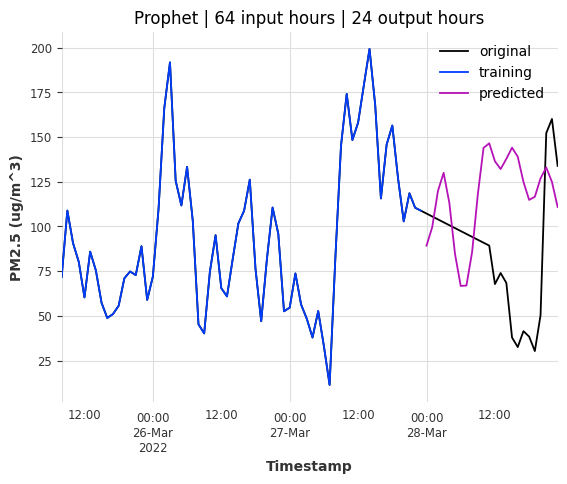

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/sxora5ol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/nwy134v9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31173', 'data', 'file=/tmp/tmp22xgl5if/sxora5ol.json', 'init=/tmp/tmp22xgl5if/nwy134v9.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelkfh8b1md/prophet_model-20240520142913.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:13 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 46.127548425128644
3000


14:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


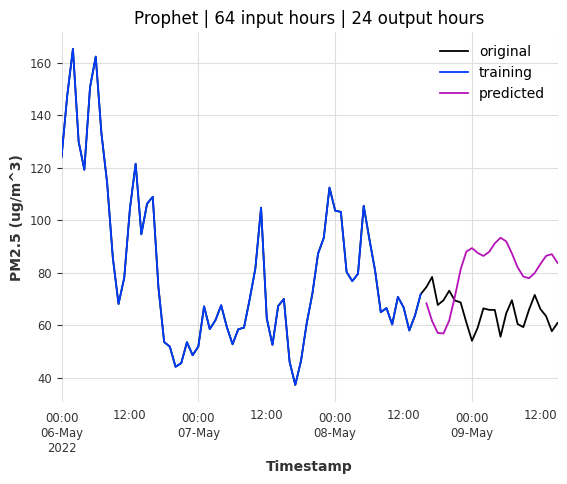

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/1ahoyf74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/97_f5dk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=324', 'data', 'file=/tmp/tmp22xgl5if/1ahoyf74.json', 'init=/tmp/tmp22xgl5if/97_f5dk4.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelliyhe7mp/prophet_model-20240520142914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:14 - cmdstanpy - INFO - Chain [1] start processing


mae for this run : 19.439579282357506
4000


14:29:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


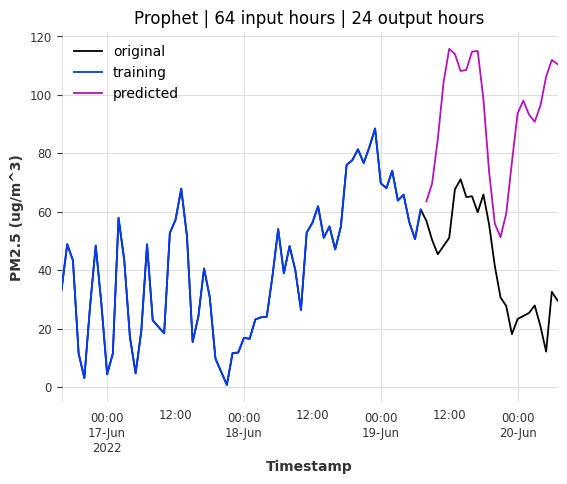

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/oqd4wqzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/472tdgfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31190', 'data', 'file=/tmp/tmp22xgl5if/oqd4wqzy.json', 'init=/tmp/tmp22xgl5if/472tdgfi.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelpr_yoo79/prophet_model-20240520142916.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:16 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 49.937006961659165
5000


14:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


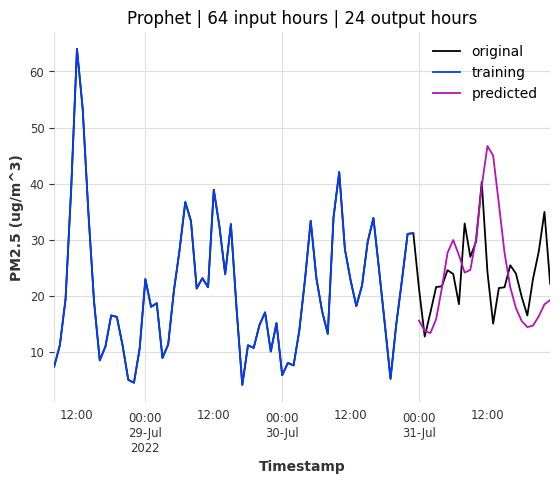

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/li9p5g1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/ojd7r3g_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88710', 'data', 'file=/tmp/tmp22xgl5if/li9p5g1w.json', 'init=/tmp/tmp22xgl5if/ojd7r3g_.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelexxzi13t/prophet_model-20240520142917.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:17 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 7.328842769709421
6000


14:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


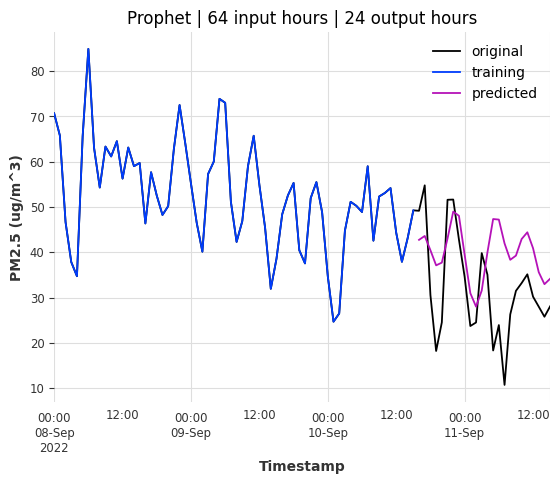

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/ld46m2id.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/qs6b48gn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71583', 'data', 'file=/tmp/tmp22xgl5if/ld46m2id.json', 'init=/tmp/tmp22xgl5if/qs6b48gn.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_model6zi8hb0q/prophet_model-20240520142918.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:18 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 10.781883289684302
7000


14:29:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


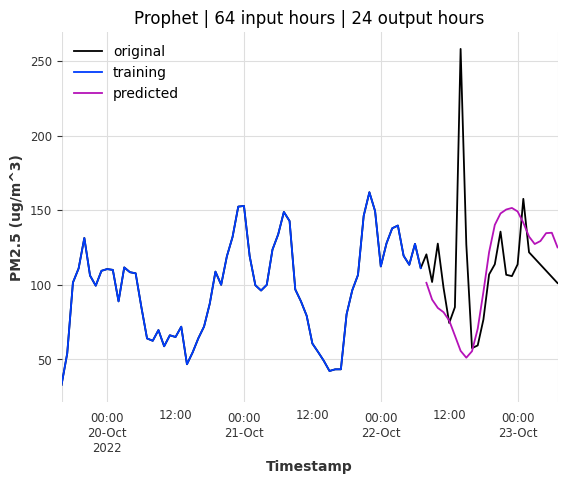

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/j9cv2u_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/4n1aezn7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68481', 'data', 'file=/tmp/tmp22xgl5if/j9cv2u_9.json', 'init=/tmp/tmp22xgl5if/4n1aezn7.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelauw906gn/prophet_model-20240520142919.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:19 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 30.45539032524673
8000


14:29:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


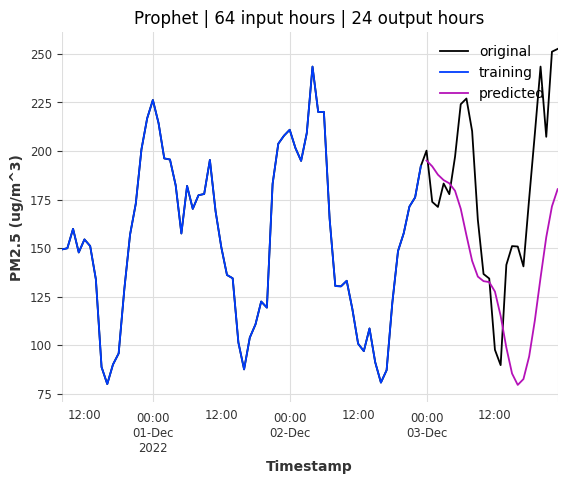

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/mpcr21u3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/qge2ui7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50820', 'data', 'file=/tmp/tmp22xgl5if/mpcr21u3.json', 'init=/tmp/tmp22xgl5if/qge2ui7s.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelhjunlbbu/prophet_model-20240520142920.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:20 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 44.721972727764474
9000


14:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


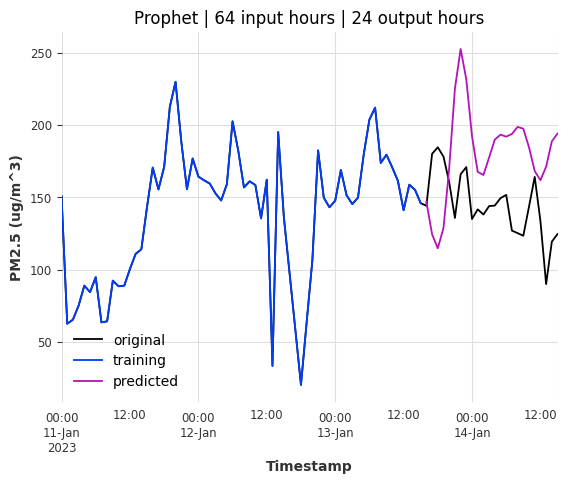

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/ipt1xvp_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/lxfnl8ff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22029', 'data', 'file=/tmp/tmp22xgl5if/ipt1xvp_.json', 'init=/tmp/tmp22xgl5if/lxfnl8ff.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelf6ud4byf/prophet_model-20240520142921.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:21 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 50.278428281337
10000


14:29:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


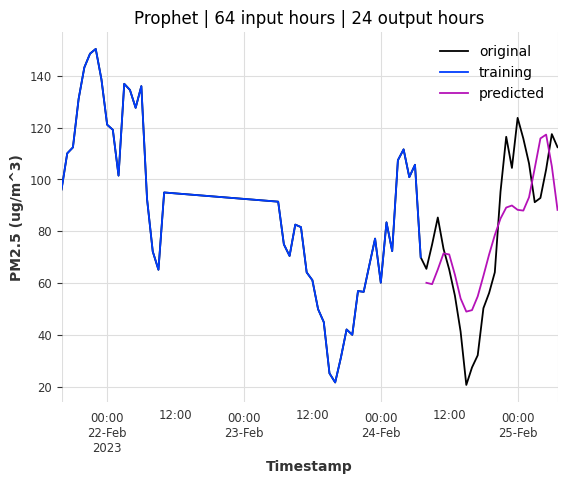

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/w24nqkig.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/n74kgrir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90114', 'data', 'file=/tmp/tmp22xgl5if/w24nqkig.json', 'init=/tmp/tmp22xgl5if/n74kgrir.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelc0lamilm/prophet_model-20240520142923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:23 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 16.61173731689942
11000


14:29:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


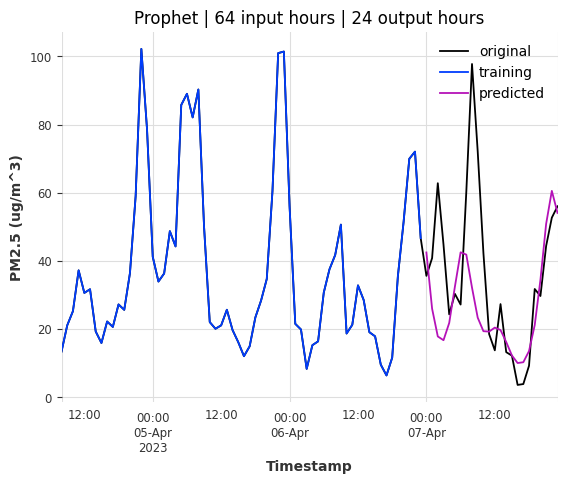

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/27mcwh4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/770xb9tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16294', 'data', 'file=/tmp/tmp22xgl5if/27mcwh4c.json', 'init=/tmp/tmp22xgl5if/770xb9tc.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_model9ky26czj/prophet_model-20240520142926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:26 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 14.04486511738115
12000


14:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


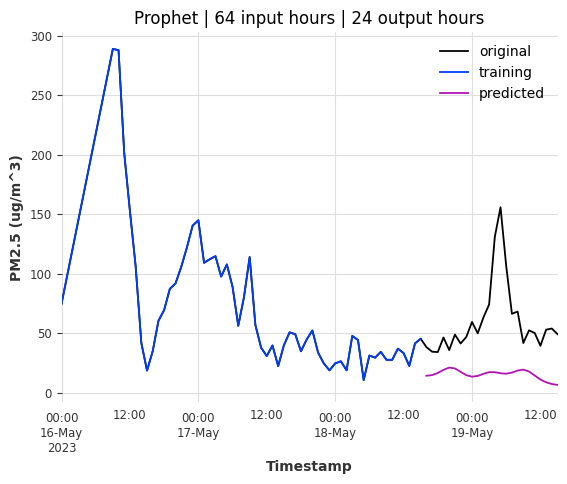

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/70dy6tk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/ft1vslfb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71963', 'data', 'file=/tmp/tmp22xgl5if/70dy6tk4.json', 'init=/tmp/tmp22xgl5if/ft1vslfb.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelcbikb97v/prophet_model-20240520142928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:28 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 44.64568171248438
13000


14:29:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


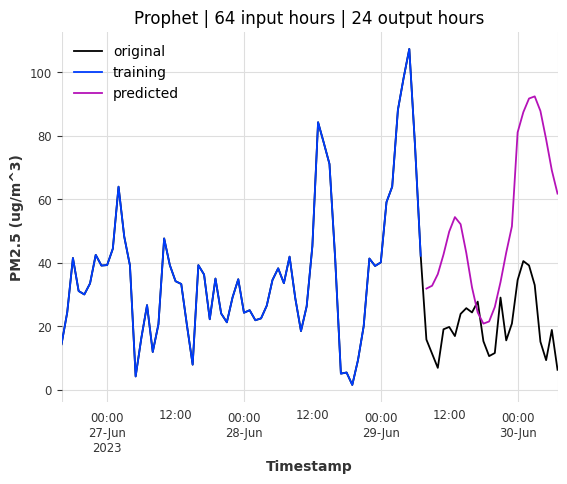

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/41xw5j83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/rmpiqxse.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30709', 'data', 'file=/tmp/tmp22xgl5if/41xw5j83.json', 'init=/tmp/tmp22xgl5if/rmpiqxse.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelyhkfisqa/prophet_model-20240520142929.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:29 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 31.761085474894333
14000


14:29:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


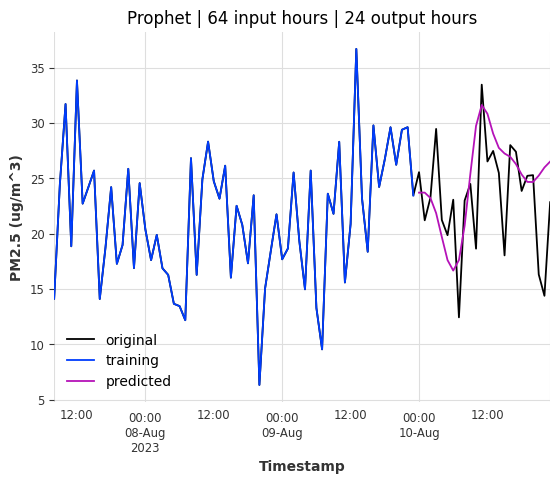

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/bdndxn14.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/mjqnc26a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31857', 'data', 'file=/tmp/tmp22xgl5if/bdndxn14.json', 'init=/tmp/tmp22xgl5if/mjqnc26a.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelrg3cyhu7/prophet_model-20240520142930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:30 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 3.741440194833968
15000


14:29:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


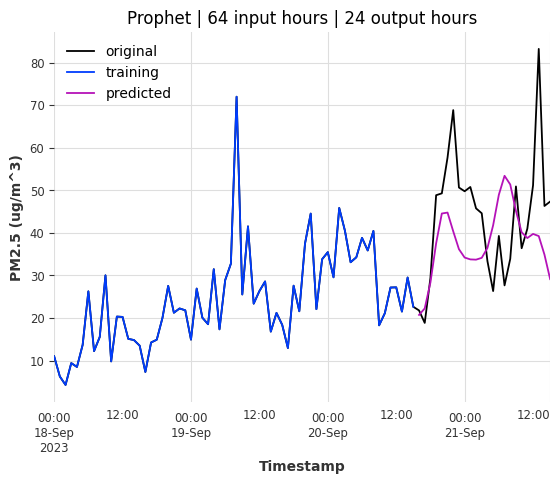

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/5qr0esz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/zu7a625s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21551', 'data', 'file=/tmp/tmp22xgl5if/5qr0esz5.json', 'init=/tmp/tmp22xgl5if/zu7a625s.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_model1sx4n14v/prophet_model-20240520142931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:31 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 12.533937719106875
16000


14:29:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


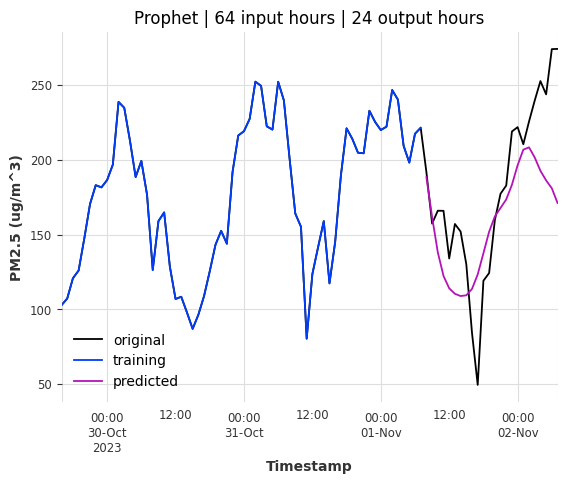

/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/pw1fl3hc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp22xgl5if/1ijwbspb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27120', 'data', 'file=/tmp/tmp22xgl5if/pw1fl3hc.json', 'init=/tmp/tmp22xgl5if/1ijwbspb.json', 'output', 'file=/tmp/tmp22xgl5if/prophet_modelu9hmkt41/prophet_model-20240520142933.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:29:33 - cmdstanpy - INFO - Chain [1] start processin

mae for this run : 33.94900338141516
17000


14:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


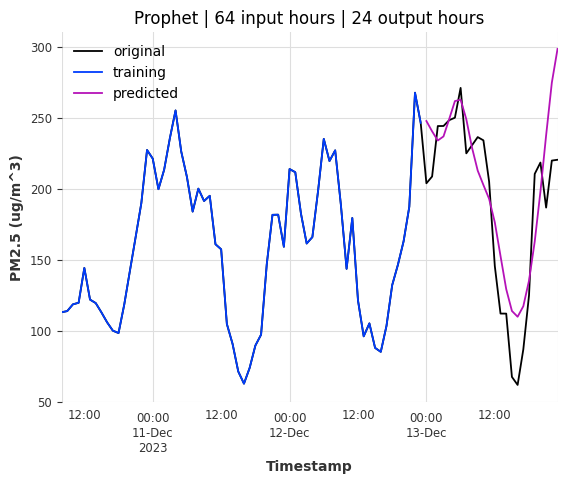

mae for this run : 28.486532656670047
[27.093986474998484, 16.88955898204709, 46.127548425128644, 19.439579282357506, 49.937006961659165, 7.328842769709421, 10.781883289684302, 30.45539032524673, 44.721972727764474, 50.278428281337, 16.61173731689942, 14.04486511738115, 44.64568171248438, 31.761085474894333, 3.741440194833968, 12.533937719106875, 33.94900338141516, 28.486532656670047]
Overall MAE: 27.15713783853434


In [ ]:

mae_list = []
for start_idx in range(0, len(df_log) - (inputhours + outputhours), 1000):
    print(start_idx)
    current_chunk = df_log.iloc[start_idx:start_idx + inputhours + outputhours]
    input_df = current_chunk.head(inputhours)

    # Convert to TimeSeries
    input_series = pd.Series(input_df, index=input_df.index)
    input_series.index = pd.to_datetime(input_series.index)
    ts = TimeSeries.from_series(input_series)

    model.fit(ts)
    pred = model.predict(outputhours)

    # Extract prediction values and create a date range for the prediction
    pred_values = pred.values().flatten()  # Assuming `pred.values()` gives the forecasted values
    pred_index = pd.date_range(start=input_series.index[-1], periods=outputhours + 1, freq='H')[1:]
    pred_series = pd.Series(pred_values, index=pred_index)
    # print(pred_series)
    # Reverse the logarithmic transformation
    current_chunk_original = np.exp(current_chunk.values) - 1
    input_series_original = np.exp(input_series.values) - 1
    pred_series_original = np.exp(pred_series.values) - 1
    # print(current_chunk_original)
    current_new = pd.Series(current_chunk_original, index=current_chunk.index)
    train_new = pd.Series(input_series_original, index=input_series.index)
    pred_new = pd.Series(pred_series_original, index=pred_index)
    actual_values = current_new[inputhours:]
    mae = np.mean(np.abs(pred_new.values - actual_values.values))
    mae_list.append(mae)
    #print(pred_series_original)
    # Plotting
    fig, ax = plt.subplots()
    current_new.plot(ax=ax, label="original")
    train_new.plot(ax=ax, label="training")
    pred_new.plot(ax=ax, label="predicted")
    plt.title("Prophet | 64 input hours | 24 output hours")
    plt.ylabel("PM2.5 (ug/m^3)")
    ax.legend()
    filename = f"prophet-64-24-{start_idx/1000}.png"
    plt.savefig(filename)
    plt.show()
    print("mae for this run : " + str(mae))
print(mae_list)
overall_mae = np.mean(mae_list)
print(f"Overall MAE: {overall_mae}")